1_results_B_other_figures.ipynb  
# Notebook for other figures (i.e. all non-transect figures made in python)

**Notebook comments:**   
- This notebook creates most of the figures (see *Notebook output*), including the preceding analysis. 
- Figures can be easily adapted via the settings at the top of the cell where the figure is made. For example, figures can be plotted for another run than CTRL.

**Notebook input:**
- runs (from modeldir):
  - all runs listed in Table 4
  - all runs listed in Table C1
- seawater observations (from obsdir): 
  - Pad_Thd_IDP2021.txt (geotraces dissolved)
  - Pap_Thp_IDP2021.txt (geotraces particle-bound)
  - Deng2018Pad_Thd_formatted_uBq_per_kg.csv
  - Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv
  - Pavia2020Pad_Thd_formatted_uBq_per_kg.csv
- sediment observations (from obsdir): 
  - sediment_compilation_table2.xlsx
- world_41x40.BGC.nc containing dust field
- world_41x40.neph_mask.nc containing nepheloid layers *(same file is created in savedir by 0_A_neph.ipynb)*
  
**Notebook output (written to savedir):**
- Fig. 2, C5, C6: particle fields
- Fig. 6
- Fig. 7
- Fig. C4
- Fig. 8 (results of computation printed out)
- Fig. 9, S8: heatmaps
- Fig. 3b, 10: depth profiles per region
- Fig. S5-S7: assess model development via Atl. zonal avg

**General information:**
- This notebook was published in the zenodo repository https://doi.org/10.5281/zenodo.10622403 along with the paper:

   - Jeemijn Scheen, Jörg Lippold, Frerk Pöppelmeier, Finn Süfke and Thomas F. Stocker. Promising regions for detecting the overturning circulation in Atlantic 231Pa/230Th: a model-data comparison. Paleoceanography and Paleoclimatology, 2025.
- Notebook author: Jeemijn Scheen, jeemijn.scheen@nioz.nl

# Set up notebook

**Easiest:** load conda environment for which this notebook worked.  
**Just use environment.yml (present in this folder) and follow** https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file

In [1]:
from pathlib import Path         # Path objects to avoid inter-platform trouble in file paths
import platform

########## SET FILE PATHS ######################################
# KEEP THE Path() FUNCTION AND USE FORWARD SLASHES '/' ON EVERY OPERATING SYSTEM
savedir = Path('./figures/')      # folder for saving figures & other output; (empty) directory needed
obsdir = Path('./data/')          # obs. data is loaded from here
modeldir = Path('./modeloutput/') # model output is loaded from here
#############################################

## CHECK FILEPATHS
# expand paths because np.loadtxt can't handle home directory ~
savedir = savedir.expanduser()
obsdir = obsdir.expanduser()
modeldir = modeldir.expanduser()
def check_dir(path):
    if not path.exists():
        raise Exception('File path ' + str(path) + ' does not exit. Correct or create first.')
check_dir(savedir)
check_dir(obsdir)
check_dir(modeldir)

## IMPORT PACKAGES
# first time install missing packages via $conda install numpy OR $pip3 install numpy (be consistent)
import numpy as np
import xarray as xr                            # $conda install -c anaconda -n cartopy xarray; needs some time
import pandas as pd
import importlib as imp                        # to import user-defined functions; renaming new name to name of deprecated package 'imp'
import math                                    # math.e or math.exp()
import xesmf as xe                             # regridding; install via conda-forge channel e.g. !conda install -c conda-forge xesmf -y

# plot-related packages:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
matplotlib.rcParams['savefig.bbox'] = 'tight'  # cuts off whitespace
import matplotlib.cm as cmp                    # colormaps
import cmcrameri.cm as cmcr                    # better colour maps (https://www.fabiocrameri.ch/colourmaps/); $conda install -c conda-forge cmcrameri
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import seaborn as sns
import scipy.stats as stats                    # used for statistics annotated in scatter plots

## CHECK PYTHON VERSION
if 1/2 == 0:
    raise Exception("You are using python 2. Please use python 3 for a correct display of the figures.") 

## PLOT SETTINGS
# larger labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

cmap = cmp.coolwarm
# cmap = cmcr.lapaz_r


# SET TIME OF INTEREST
# time step of interest in all cells below
t = -1

# set a random run as control simulation; doesn't matter as only model grid is used
fnctrl = modeldir / 'CTRL_NEWNR'

## LOAD USER-DEFINED FUNCTIONS
import functions as f                          # my own functions; call via f.function_name()

In [2]:
imp.reload(f)   # shows how to reload functions after editing functions.py w/o kernel restart

<module 'functions' from '/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py'>

# Load runs  

In [3]:
## ORGANIZE RUNNAMES & LABELS:
# SAVE ORIGINAL RUNNAMES IN CLEARER VARIABLES WITH CLEARER RUNNAMES

########### RESULT OF TUNING RUNS #################################################
ctrl = 'CTRL_NEWNR'                    # control run (new during review; with No Remineralization term, NR)
NO_NEPH = 'NO_NEPH___'                 # with sigma_nephs = 0
NO_DUST = 'NO_DUST___'                 # with sigma_dusts = 0
ADD_REM = 'CTRL_NEWYR'                 # with added remineralization term (as in tuning); dont use, only check
# (an extra Remin. term was still present during tuning; this term was dropped from other runs during review)

########### FACTORIAL RUNS: VARYING AMOC AND/OR PARTICLE FIELDS ###################
## weak AMOC spinups
# not used in manuscript directly; are 'spinups' to adjust to FW forcing; from those runs PFREE_14SV etc are started
weak_AMOC7 = 'WEAK_010SV'   # FW forcing of 0.10 Sv in NAtl; compensated; gives 14.0 Sv AMOC is 79%; free particles
weak_AMOC6 = 'WEAK_015SV'   # FW forcing of 0.15 Sv in NAtl; compensated; gives 11.2 Sv AMOC; free particles
weak_AMOC5 = 'WEAK_020SV'   # FW forcing of 0.20 Sv in NAtl; compensated; gives 8.6 Sv AMOC is 48%; free particles

# weak AMOC, with free=dynamic particles
# PFREE_18SV = ctrl         # already exists
PFREE_14SV = 'PFREE_14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV); particle field (PF) free
PFREE_11SV = 'PFREE_11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV); particle field (PF) free
PFREE_09SV = 'PFREE_09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV); particle field (PF) free

# 18 Sv AMOC (PI), scaling particle export
PFX1__18SV = 'PFX1__18SV'
PFX2__18SV = 'PFX2__18SV'
PFX3__18SV = 'PFX3__18SV'
PFX5__18SV = 'PFX5__18SV'
PFD2__18SV = 'PFD2__18SV'

# weak AMOC, scaling particle export
PFD2__14SV = 'PFD2__14SV'   # AMOC of ca 14 Sv (so 0.10Sv FW and restart from WEAK_010SV); particle field divided by 2
PFD2__11SV = 'PFD2__11SV'   # AMOC of ca 11 Sv (so 0.15Sv FW and restart from WEAK_015SV); particle field divided by 2
PFD2__09SV = 'PFD2__09SV'   # AMOC of ca 9 Sv (so 0.20Sv FW and restart from WEAK_020SV); particle field divided by 2

PFX1__14SV = 'PFX1__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 1 
PFX1__11SV = 'PFX1__11SV'   # i.e. same particles as CTRL but w/o seasonal cycle
PFX1__09SV = 'PFX1__09SV'   # (difference is not/barely visible in yearly average effects) 

PFX2__14SV = 'PFX2__14SV'   # AMOC of ca 14 Sv; particle field multiplied by 2
PFX2__11SV = 'PFX2__11SV'   # etc.
PFX2__09SV = 'PFX2__09SV'

PFX3__14SV = 'PFX3__14SV'
PFX3__11SV = 'PFX3__11SV'
PFX3__09SV = 'PFX3__09SV'

PFX5__14SV = 'PFX5__14SV'
PFX5__11SV = 'PFX5__11SV'
PFX5__09SV = 'PFX5__09SV'
##################################################################################

# set labels used in figures:
labels = {ctrl:'CTRL', NO_DUST: 'NO_DUST', NO_NEPH: 'NO_NEPH', ADD_REM: 'ADD_REM', 
          PFX1__18SV: 'Px1_18Sv', PFX2__18SV: 'PART X2', PFX3__18SV: 'PART X3', 
          PFX5__18SV: 'PART X5', PFD2__18SV: 'PART X0.5', 
          PFREE_14SV: 'Pdyn_14Sv', PFREE_11SV: 'Pdyn_11Sv', PFREE_09SV: 'Pdyn_9Sv',
          PFD2__14SV: 'P/2_14Sv', PFD2__11SV: 'P/2_11Sv', PFD2__09SV: 'P/2_9Sv',
          PFX1__14SV: 'Px1_14Sv', PFX1__11SV: 'Px1_11Sv', PFX1__09SV: 'Px1_9Sv',
          PFX2__14SV: 'Px2_14Sv', PFX2__11SV: 'Px2_11Sv', PFX2__09SV: 'Px2_9Sv',
          PFX3__14SV: 'Px3_14Sv', PFX3__11SV: 'Px3_11Sv', PFX3__09SV: 'Px3_9Sv',
          PFX5__14SV: 'Px5_14Sv', PFX5__11SV: 'Px5_11Sv', PFX5__09SV: 'Px5_9Sv',
          weak_AMOC5: '0.20Sv FW NAtl', weak_AMOC6: '0.15Sv FW NAtl', weak_AMOC7: '0.10Sv FW NAtl', 
          }

# in the model output simulation year 0 is called 1765 CE (pre-industrial)
yr = '.0001765'
spinup_yr = 1765

In [4]:
## LOAD RUNS

########### SETTINGS ########################################
## For all figures:
runs = [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV, 
        PFD2__18SV, PFD2__14SV, PFD2__11SV, PFD2__09SV,
        PFX1__18SV, PFX1__14SV, PFX1__11SV, PFX1__09SV, 
        PFX2__18SV, PFX2__14SV, PFX2__11SV, PFX2__09SV,
        PFX3__18SV, PFX3__14SV, PFX3__11SV, PFX3__09SV, 
        PFX5__18SV, PFX5__14SV, PFX5__11SV, PFX5__09SV,
        NO_NEPH, NO_DUST, ADD_REM]

## FASTER & LESS MEMORY ALTERNATIVE FOR Fig. 2,6,7,9,C2:
# runs = [ctrl, NO_DUST]  # only using CTRL but need to load multiple runs
##############################################################

[datas, data_fulls] = f.load_data_multiple_runs(modeldir, runs, spinup_yr, 
                                                z_in_km=True, add_more_PaTh_vars=True)
#### INFO ####
# - timeseries data are loaded into 'datas' and have annual resolution
# - 3D variables are loaded into 'data_fulls' with lower time resolution, or only the last time step
# datas & data_fulls are dicts with keys=runnames, values=Xarray Dataset with model output of that run
##############

# Prepare landmask for surface plots
land_mask = f.get_landmask(data_fulls[runs[0]])  # doesn't matter which run (only uses model grid)

# Load observations  
Seawater observations:   
- 'obs_d': contains dissolved Pa, Th as in tuning notebooks, i.e., from Ng et al., Deng et al., Pavia et al. and GEOTRACES (all cruises except Arctic)
- 'obs_p': contains particle-bound Pa, Th as in tuning notebooks, i.e., from GEOTRACES (all cruises except Arctic)   

Sediment observations:
- 'obs_sed': contains compiled database of Atlantic sedimentary Pa/Th

In [5]:
## SEDIMENT OBS ##########################

## 1.) load sediment obs in the Atlantic:
obs_sed = pd.read_excel(obsdir / "sediment_compilation_table2.xlsx")
# if XLRDError: Excel xlsx file; not supported => do $conda update pandas

## 2.) rename and shuffle columns to be similar to obs_d and obs_p
obs_sed = obs_sed.rename(columns={'Core':'core', 'Latitude':'lat', 'Longitude':'lon', 'Depth [m]':'z', 
                                  'Reference':'reference', 'Region':'region',
                                  'Holocene Pa/Th average':'path_ratio_p', 
                                  'SE of included samples':'path_ratio_p_err',
                                  })

# reorder columns
old_len = len(obs_sed.columns)
column_order = [0,3,2,4,1]+list(range(5,10))
obs_sed = obs_sed[obs_sed.columns[column_order]]
assert len(obs_sed.columns) == old_len, "ERROR: some columns disappeared (1)"

# add column age_ka explaining that Holocene average (0-8 ka)
obs_sed['age_ka'] = ['Hol_avg'] * len(obs_sed.index)  # we renamed column 'Holocene Pa/Th average' above to 'path_ratio_p'
print('nr of Holocene cores:', len(obs_sed.index))

# checks
for this_core in obs_sed.core.unique():
    assert len(obs_sed[obs_sed.core == this_core].z.unique()) == 1, "z of core " + this_core + " is not unique."
    assert len(obs_sed[obs_sed.core == this_core].lat.unique()) == 1, "lat of core " + this_core + " is not unique."
    assert len(obs_sed[obs_sed.core == this_core].lon.unique()) == 1, "lon of core " + this_core + " is not unique."
    
assert len(obs_sed[obs_sed.lon.isna()]) == 0, "not all rows are correct"

# change longitude axis to bern3d version; keep a lon_0_360 version as reference
obs_sed['lon_0_360'] = f.convert_minus_180_plus_180_lon_to_0_360_lon(obs_sed['lon'].values)  # change from [-180,180] to [0,360]
obs_sed['lon'] = f.convert_0_360_lon_to_model_lon(obs_sed['lon_0_360'].values)               # change from [0,360] to Bern3D [100,460]

# reorder columns again
old_len = len(obs_sed.columns)
column_order = [0,1,2,3,11,4,5,7,9,10,6,8]
obs_sed = obs_sed[obs_sed.columns[column_order]]
assert len(obs_sed.columns) == old_len, "ERROR: some columns disappeared (2)"

## 4.) take average per model grid cell
[obs_sed_model_grid, obs_sed_ave, obs_sed_ave_num] = f.obs_to_model_grid(obs_sed.set_index(['lon', 'lat', 'z'], 
                                                                                           inplace=False),
                                                                         fnctrl, weight_avg_by_uncertainty=True)
obs_sed_model_grid = obs_sed_model_grid.reset_index().set_index(['lon_sim_100_to_460','lat_sim','z_sim'], 
                                                                inplace=False)  # change index from obs to model grid
del obs_sed_ave  # got to complicated with str and floats in the age_ka column; dont want to use this anyway! 

## 5.) add column delta_z in m:  if negative, then model cell z lies deeper than core z
obs_sed_model_grid['delta_z'] = obs_sed_model_grid.z - obs_sed_model_grid.index.get_level_values('z_sim')
# note: delta_z is to nearest grid cell and says nothing about Fig. 7a, where model BOTTOM is compared to sed (delta_z of that can be much larger)

nr of Holocene cores: 104
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.


What is the average measurement uncertainty in our Holocene sediment compilation?  
This is used as threshold for detectability (heat map, Fig. 9)

In [6]:
print('median measurement uncertainty:', obs_sed.path_ratio_p_err.median())
print('mean measurement uncertainty:', obs_sed.path_ratio_p_err.mean())
# obs_sed.path_ratio_p_err.hist(bins=23)  # histogram of measurement uncertainties

median measurement uncertainty: 0.003
mean measurement uncertainty: 0.0038167467848639666


In [7]:
## SEAWATER OBS  ################################### TAKES A WHILE (e.g. 2 minutes) ###########

## DISSOLVED SEAWATER OBS ###############

# load geotraces ICP 2021 observations; has lon [0,360]
fnobs = obsdir / 'Pad_Thd_IDP2021.txt'
obs_d_geotraces_incl_arctic = f.get_obs_geotraces(fnobs, dissolved_type='BOTTLE', 
                                                  drop_meta_data=True, good_quality=True)
obs_d_geotraces = obs_d_geotraces_incl_arctic[~obs_d_geotraces_incl_arctic.cruise.isin(
    ['GN01','GN02','GN03','GN04'])].copy()

# load other dissolved observations from 3 additional studies
obs_d_deng = f.get_obs_other(obsdir / 'Deng2018Pad_Thd_formatted_uBq_per_kg.csv') # is geovide
obs_d_ng = f.get_obs_other(obsdir / 'Ng2020Pad_Thd_formatted_dpm_per_1000kg.csv')
for var in ['Pad','Pad_err','Thd','Thd_err']:
    # convert dpm/1000kg to uBq/kg; using 1 dpm = 1/60 * 1e6 uBq
    obs_d_ng[var] = obs_d_ng[var] / 60.0 * 1e3  
obs_d_pavia = f.get_obs_other(obsdir / 'Pavia2020Pad_Thd_formatted_uBq_per_kg.csv')

# combine all dissolved data excl. Arctic
obs_d = pd.concat([obs_d_geotraces,obs_d_deng,obs_d_ng,obs_d_pavia], join='outer')

# add column with ratio
obs_d['path_ratio_d'] = obs_d.Pad / obs_d.Thd

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_d, obs_d_ave, obs_d_ave_num] = f.obs_to_model_grid(obs_d, fnctrl)
obs_d.reset_index(inplace=True)


## PARTICLE-BOUND SEAWATER OBS ##########################
fnobs = obsdir / 'Pap_Thp_IDP2021.txt'
obs_p_incl_arctic = f.get_obs_geotraces(fnobs, drop_meta_data=True, p_type='combined', good_quality=True)
obs_p = obs_p_incl_arctic[~obs_p_incl_arctic.cruise.isin(['GN01','GN02','GN03','GN04'])].copy()

# add column with ratio
obs_p['path_ratio_p'] = obs_p.Pap / obs_p.Thp

# easier to grab panda coords if lat,lon,z are not an index 
# => average obs to model grid
[obs_p, obs_p_ave, obs_p_ave_num] = f.obs_to_model_grid(obs_p, fnctrl)
obs_p.reset_index(inplace=True)

/Users/jeemijnscheen/Documents/PHD/PhD_notebooks/functions.py:700: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(fnobs, sep='\t', header=39, dtype={'Cruise Aliases':'str'})


Column 21 has mixed types as it contains quality control variables, which can be int or string. Fine.
Reduced dataset from  96184  rows to  2166  rows after deleting nans.
Reduced dataset from  129  rows to  129  rows after deleting nans.
Reduced dataset from  20  rows to  20  rows after deleting nans.
Reduced dataset from  126  rows to  126  rows after deleting nans.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Reduced dataset from  102686  rows to  860  rows after deleting nans.
Reduced dataset from  1009  rows to  1003  rows after deleting nans.
obs_to_model_grid(): found 'Pap' as well as 'path_ratio_p' in obs.columns; continuing with Pap.
Starting to match obs to nearest model coords... 
... finished matching.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_gr

In [8]:
## define basins/cruises of interest
# using obs_d since obs_p would only give a subset of that
cruises_all = np.unique(obs_d.cruise)                      # already excludes Arctic cruises

# only 1 basin incl its SO sector
cruises_Atl = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10','GIPY04', 'GIPY05', 
               'deng', 'ng'] # deng=geovide
cruises_Pac = ['GP16', 'GPc01', 'GSc02', 'pavia']

cruises_Atl_wo_SO = ['GA02', 'GAc02', 'GA03', 'GAc03', 'GA10',
                     'deng', 'ng'] # deng=geovide
cruises_Pac_wo_SO = ['GP16', 'GPc01']

# SO (Southern Ocean)
cruises_SO = ['GSc02','GIPY04', 'GIPY05','GIpr05', 'pavia'] 
# chosing here the definition that GA10 is not SO

# for testing purposes; not used
cruises_Arctic = ['GN01', 'GN02', 'GN03', 'GN04']  
cruises_Labr = ['GN02']

# Fig. 2, C5, C6: particle fields

run =  CTRL_NEWNR


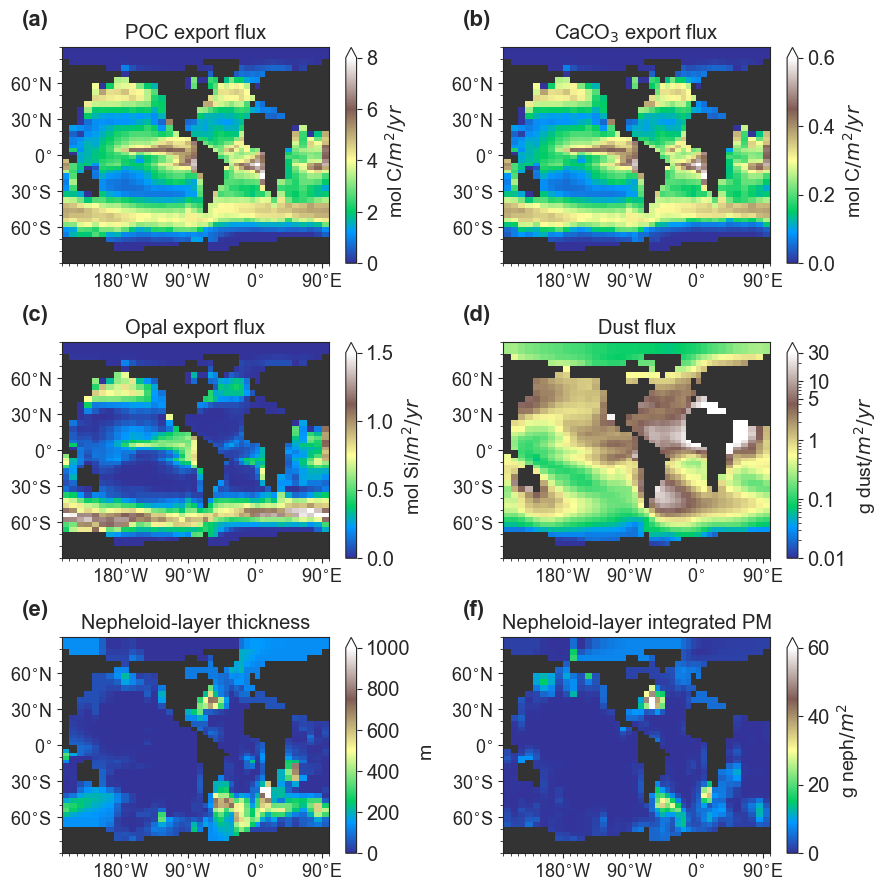

In [9]:
# Fig. 2: particle export map: all particles (biologic & lithogenic) for CTRL run

####### SETTINGS ##################################
run = ctrl
alpha = 1.0              # transparency
this_cmap = cmp.terrain  # nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
dust_log = False
cbar_fontsize = 14

vars = ['FLDPOM', 'FLDCA', 'FLDOP', 'dust', 'neph_thickness', 'neph_PM'] # short titles; used as keys to fill dicts below
titles = {'FLDPOM':'POC', 'FLDCA':'CaCO$_3$', 'FLDOP':'Opal', 'dust':'Dust flux', 
          'neph_thickness':'Nepheloid-layer thickness', 'neph_PM':'Nepheloid-layer integrated PM'}
vmins = {'FLDPOM':0.0, 'FLDCA':0.0, 'FLDOP':0.0, 'dust':0.01, 'neph_thickness':0, 'neph_PM':0}
         # dust: 0.01 because logarithmic scale plots cannot start at 0! Gives "invalid vmin or vmax" error
vmaxs = {'FLDPOM':8.0, 'FLDCA':0.6, 'FLDOP':1.5, 'dust':30, 'neph_thickness':1000, 'neph_PM':60}
# biological flux output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
units = {'FLDPOM':'mol C$/m^{2}/yr$', 'FLDCA':'mol C$/m^{2}/yr$', 'FLDOP':'mol Si$/m^{2}/yr$', 
         'dust':'g dust$/m^{2}/yr$', 'neph_thickness':'m', 'neph_PM':'g neph$/m^2$'}
####################################################

# read in dust field (based on Mahowald et al., 2006, JGR)
bgc_input_fields = xr.open_dataset(obsdir / 'world_41x40.BGC.nc', decode_times=False, engine="netcdf4")
dust_field = bgc_input_fields.dust_dep_mod.mean(dim='time') * 1000 # average over 12 months; result in g-dust/m**2/s
# processed here same way as in model: conversion of dust-units; kg-dust/m^2/s to g-dust/m**2/s
# now in addition convert /s to /yr
dust_field = dust_field * 365.25 * 24 * 3600  # g-dust/m**2/yr

# read in nepheloid layers
neph_fields = xr.open_dataset(obsdir / 'world_41x40.neph_mask.nc')
neph_thickness = neph_fields.neph_thickness
neph_PM = neph_fields.neph_PM / 1e3 * 1e4 # unit conversion from mg/cm2 to g/m2

# plotting
full_obj = data_fulls[run]
print('run = ',run)

sns.set_style('ticks')
fig, ax = plt.subplots(3, 2, figsize=(9,9))

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner

## biological particles
# FIRST 3 SUBPLOTS (row 1 & half of row 2): loop over 3 biological particles
for i,var in enumerate(vars[0:3]):
    row = i // 2
    col = i % 2

    Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
    cpf = ax[row,col].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, vmin=vmins[var], vmax=vmaxs[var])
    cbar = fig.colorbar(cpf, ax=ax[row,col], extend='max')
    cbar.set_label(label=units[var], fontsize=cbar_fontsize)
    
    ax[row,col].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[row,col].set_title(titles[var] + ' export flux')
    ax[row,col].text(-0.15, 1.1, '(' + chr(ord('a')+i) + ')', transform=ax[row,col].transAxes, 
                     size=16, weight='bold')
    
## lithogenic particles
# 4TH SUBPLOT: dust (logarithmic scale)
var = vars[3]
row = 1
col = 1
Z = dust_field.values
cpf = ax[row,col].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, 
                         norm=matplotlib.colors.LogNorm(vmin=vmins[var], vmax=vmaxs[var]))
cbar = fig.colorbar(cpf, ax=ax[row,col], extend='max')
cbar.set_label(label=units[var], fontsize=cbar_fontsize)
cticks_dust = [0.01,0.1,1,5,10,30]
cbar.set_ticks(cticks_dust)
cbar.set_ticklabels(cticks_dust)  # such that not printed as 10^n

ax[row,col].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
ax[row,col].set_title(titles[var])
ax[row,col].text(-0.15, 1.1, '(d)', transform=ax[row,col].transAxes, 
                 size=16, weight='bold')
    
# SUBPLOT 5 & 6 (ROW 3): neph
for i,var in enumerate(vars[4:6]):
    row = 2
    col = i
    if var == 'neph_thickness':
        Z = neph_thickness.values
    elif var == 'neph_PM':
        Z = neph_PM.values
    cpf = ax[row,col].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, vmin=vmins[var], vmax=vmaxs[var])
    cbar = fig.colorbar(cpf, ax=ax[row,col], extend='max')
    cbar.set_label(label=units[var], fontsize=cbar_fontsize)

    ax[row,col].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
    ax[row,col].set_title(titles[var])
    ax[row,col].text(-0.15, 1.1, '(' + chr(ord('e')+i) + ')', transform=ax[row,col].transAxes, 
                     size=16, weight='bold')

for row in [0,1,2]:
    for col in [0,1]:
        ax[row,col].set_yticks(range(-60,70,30))
        ax[row,col].set_xticks([180,270,360,450])
        ax[row,col].set_xticklabels([-180,-90,0,90])  # converted the above manually from [100,460] to [-180,180]
        ax[row,col].xaxis.set_minor_locator(MultipleLocator(10))
        ax[row,col].yaxis.set_minor_locator(MultipleLocator(10))

        # add '°W' etc
        ax[row,col] = f.convert_ticks_of_map(ax[row,col], Bern3D_grid=True)
        ax[row,col].tick_params(axis='x', labelsize=13)
        ax[row,col].tick_params(axis='y', labelsize=13)
    
plt.tight_layout()
plt.savefig(savedir / 'fig2_particles_PI_biol_lith.pdf')
plt.show()

# First 3 panels: these patterns and colourbar maxima nicely correspond to roth14esd Fig. 1 after converting mol to mmol and 
# when converting POC from C to P via dividing by redcp = 117
# (1 mol P = 1 mol PO4 etc)

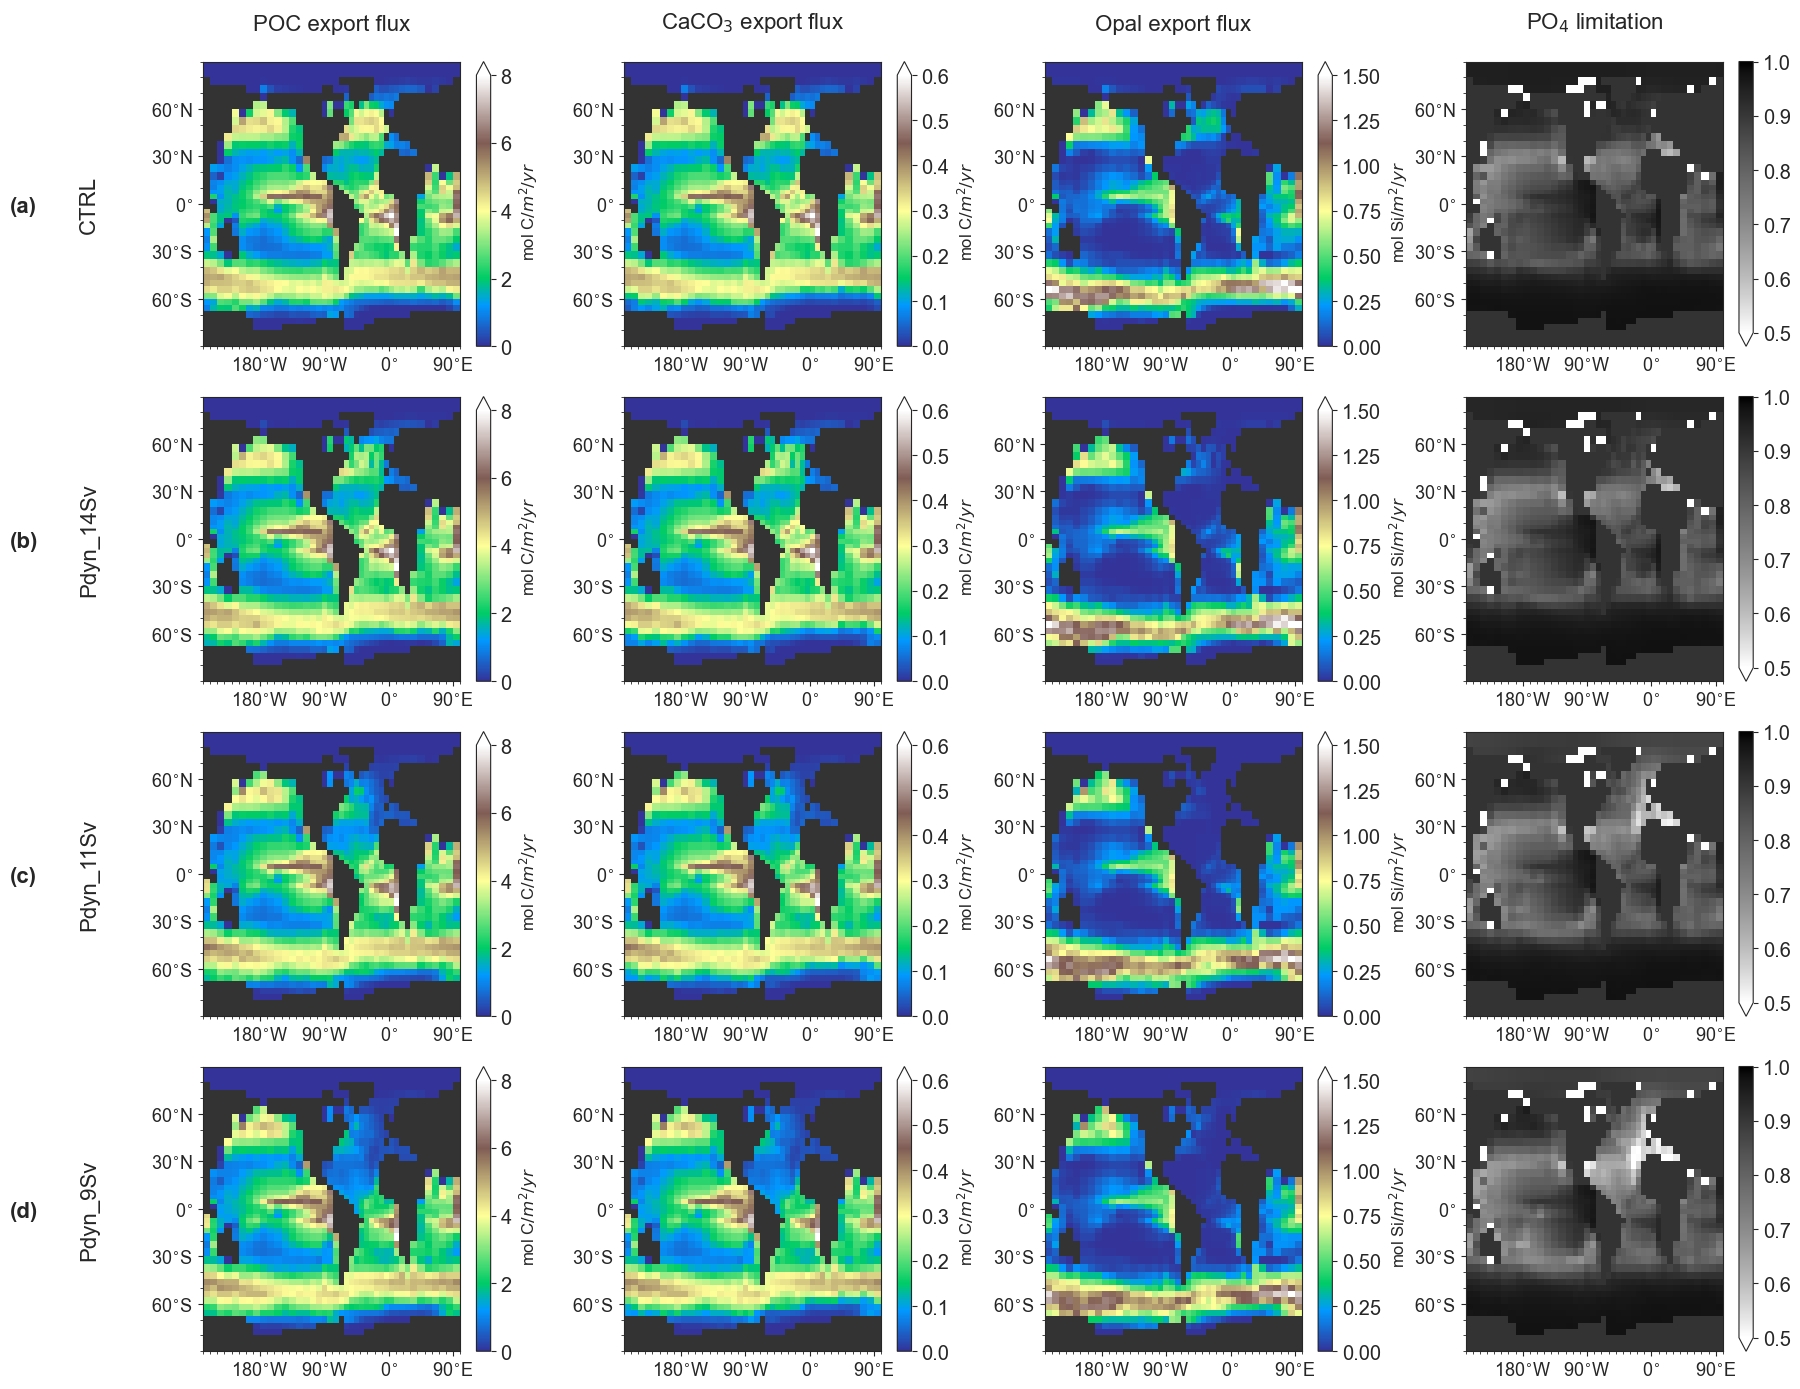

In [10]:
# Fig. C5-C6: biological particle fields for varying AMOC runs

####### SETTINGS ##################################
anom = False                  # this switches between Fig. C5 and C6

zoom_atl = False
alpha = 1.0                   # transparency
this_cmap_conc = cmp.terrain  # nice cmaps cmp: Dark2, Set2, Accent, Spectral_r, copper 
this_cmap_po4lim = cmcr.grayC_r  # nice cmaps cmcr:acton, tokyo_r, grayC
dust_log = False
cbar_fontsize = 12

# arrays in order of subplots:
vmins = [0.0, 0.0, 0.0, 0.5]
vmaxs = [8.0, 0.6, 1.5, 1.0]
vmaxs_anom = [4, 0.3, 0.75, 0.3]
titles = np.asarray(['POC export flux', 'CaCO$_3$ export flux', 
                     'Opal export flux', 'PO$_4$ limitation'])
# biological flux output is in C/(m^2*s) resp. Si/(m^2*s) but will convert s to yr below
units = np.asarray(['mol C$/m^{2}/yr$', 'mol C$/m^{2}/yr$', 'mol Si$/m^{2}/yr$', ''])
####################################################

these_runs = [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV]  # are runs Pdyn_ 
nr_rows = len(these_runs)
nr_cols = 4                   # variables POC CaCO3 opal and PO4_limitation

sns.set_style('ticks')
if zoom_atl:
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(12,nr_rows*3.5))
else:
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(18,nr_rows*3.5))

X,Y = np.meshgrid(data_fulls[runs[0]].lon_u, data_fulls[runs[0]].lat_u) # u grid because pcolor needs left bottom corner

for i,var in enumerate(['FLDPOM', 'FLDCA', 'FLDOP', 'FLDPLIM']):
    for row, run in enumerate(these_runs):
        full_obj = data_fulls[run]
        if var == 'FLDPLIM':
            # prepare weights for depth-weighted average over euphotic zone
            z_layer1 = (full_obj.z_w[1] - full_obj.z_w[0]).item() * 1000  # m
            z_layer2 = (0.075 - full_obj.z_w[1]).item() * 1000            # m; euphotic zone is 75 m deep (z_w[2] = 81 m)
            Z = np.average(full_obj[var].isel(time=t, z_t=slice(0,2)), axis=0, weights=[z_layer1, z_layer2])
            this_cmap = this_cmap_po4lim
            this_extend = 'min'
        else:
            Z = full_obj[var].isel(time=t).values * 365.25 * 24 * 3600 # convert /s to /yr
            this_cmap = this_cmap_conc
            this_extend = 'max'

        if not anom or row == 0:
            # non-anomaly plot
            cpf = ax[row,i].pcolormesh(X, Y, Z, cmap=this_cmap, alpha=alpha, 
                                       vmin=vmins[i], vmax=vmaxs[i])
            cbar = fig.colorbar(cpf, ax=ax[row,i], extend=this_extend)
            cbar.set_label(label=units[i], fontsize=cbar_fontsize)
        if anom: 
            if row == 0:
                Z_ref = Z
            else:
                # anomaly plot
                cpf = ax[row,i].pcolormesh(X, Y, Z-Z_ref, cmap=cmcr.vik, alpha=alpha, 
                                           vmin=-vmaxs_anom[i], vmax=vmaxs_anom[i])
                cbar = fig.colorbar(cpf, ax=ax[row,i], extend='both')
                cbar.set_label(label=units[i], fontsize=cbar_fontsize)

        ax[row,i].pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land

for row in range(nr_rows):
    if not anom or row == 0:
        ax[row,0].set_ylabel(labels[these_runs[row]]+'\n\n', fontsize=16)
    if anom and row > 0:
        ax[row,0].set_ylabel(labels[these_runs[row]]+' - '+labels[these_runs[0]]+'\n\n', fontsize=16)
    ax[row,0].text(-0.75, 0.47, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=16, weight='bold')
    for col in range(nr_cols):
        if row == 0:
            ax[row,col].set_title(titles[col]+'\n', fontsize=16)
        if zoom_atl:
            ax[row,col].set_xticks([270,300,330,360,390])
            ax[row,col].set_xticklabels([-90,-60,-30,0,30])        
            ax[row,col].set_xlim(258,382)
        else:
            ax[row,col].set_xticks([180,270,360,450])
            ax[row,col].set_xticklabels([-180,-90,0,90])  # converted the above manually from [100,460] to [-180,180]
        ax[row,col].set_yticks(range(-60,70,30))
        ax[row,col].xaxis.set_minor_locator(MultipleLocator(10))
        ax[row,col].yaxis.set_minor_locator(MultipleLocator(10))

        # add '°W' etc
        ax[row,col] = f.convert_ticks_of_map(ax[row,col], Bern3D_grid=True)
        ax[row,col].tick_params(axis='x', labelsize=13)
        ax[row,col].tick_params(axis='y', labelsize=13)
    
plt.tight_layout()
if anom:
    plt.savefig(savedir / ('figC6_particle_response_anom.pdf'))
else:
    plt.savefig(savedir / ('figC5_particle_response.pdf'))
plt.show()

# Fig. 6 (scatter plot version of Fig. 5)  
Fig. 5 itself is located in 1_results_A_transect_figures.ipynb  

In [11]:
## PREPARATION

# define 'margins' i.e. model grid cells that are adjacent to the coast
# only need to list here those that are actually in GA02, GA03 or in sediment cores

# use that res_d/p_table & this_obs_d/p_ave have 'lat_sim', 'lon_sim_100_to_460'

############# DEFINE MARGINS FOR SEAWATER OBS ##########
# # made via copy over print out from 1_results_A_transect_figures.ipynb "plot trajectory on Bern3D grid" with verbose = True
# NEIGHBOURS ARE ADJACENT TO COAST IN LAT OR LON OR DIAGONAL DIRECTION
margin_cells_GA02_GA03 = [(321.5,-27.5), (328.5,-10.5), (328.5,-7.5), (328.5,-4.5), (314.5,4.5), (314.5,57.5), 
                          (321.5,57.5), (321.5,62.5), (328.5,62.5), (335.5,62.5), (349.5,62.5),       # GA02 index 8,13,14,15,18,36-40,42 
                          (286.0,27.5), (286.0,32.5), (293.5,37.5), (342.5,17.5), (342.5,32.5), (349.5,37.5), # GA03 index 1,2,3,14,18,20
                          ]

############# DEFINE MARGINS FOR SEDIMENT OBS ##########
# NEIGHBOURS ARE ADJACENT TO COAST IN LAT OR LON OR DIAGONAL DIRECTION
margin_cells_sed = [2,5,18, #   4,7,25,
                    23,24,25,26,27,28,29,30,31,32, # 30,31,32,33,34,35,36,37,38,39,
                    34,43,44,45,46,  #  42,51,52,53,54,
                    78,79,80,81,82,83,84,  #  87,88,89,90,91,92,93,
                    86,87,88,89,90,91,92,93,94,95,96,97,98,   # 95,96,97,98,99,100,101,102,103,104,105,106,107,
                    100]  #110]


run =  CTRL_NEWNR
variable =  Pad
cruise =  GA03

nr of data points: 237
nr of non-nan data in model: 229
nr of non-nan data in obs: 237


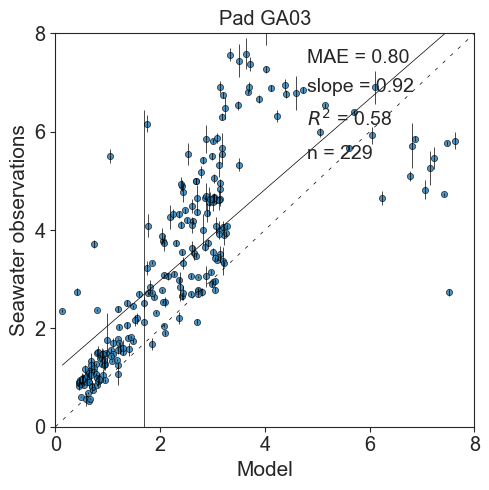

In [12]:
## VERSION OF 1 PANEL TO PLAY AROUND WITH
# add scatter plot of the same data - 1 panel

########### SETTINGS ########################################
run = ctrl
cruise = 'GA03'       # pick from: 'GA02','GAc02','GA03','GA10','GIPY04','GIPY05','GIpr05','GP16','GPc01','GSc02','deng','ng','pavia'
variable = 'Pad'   # see vmaxs keys for options

error_bars = True
plot_fit = True
size = 20          # marker size for obs
this_vmin = 0.0
# vmaxs = {'Pad' : 8, 'Thd' : 25, 'Pap' : 0.2, 'Thp' : 2,
#          'path_ratio_d' : 1, 'path_ratio_p' : 0.2} # same as in other Fig.
vmaxs = {'Pad' : 8, 'Thd' : 25, 'Pap' : 0.17, 'Thp' : 2,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}  # Pap lower because no vals >0.17
########### END OF SETTINGS #################################
print('run = ',run)
print('variable = ',variable)
print('cruise = ',cruise)
title = variable + ' ' + cruise

# prepare obs data and model data (based on obs data slice of cruise)
if variable in ['Pad', 'Thd', 'path_ratio_d']:
   this_obs_ave = obs_d_ave[obs_d_ave.cruise==cruise].dropna(how='all')
   this_obs_ave = this_obs_ave[this_obs_ave[variable].notna()]  # only keep subset non-nan for this variable
   [this_res_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                            obs_ave=this_obs_ave, convert_unit_to_obs=True)
   this_res_table['path_ratio_d'] = this_res_table.Pad / this_res_table.Thd
elif variable in ['Pap', 'Thp', 'path_ratio_p']:
   this_obs_ave = obs_p_ave[obs_p_ave.cruise==cruise].dropna(how='all')
   if variable == 'path_ratio_p':
      this_obs_ave['path_ratio_p'] = this_obs_ave.Pap / this_obs_ave.Thp
      # Q=a/b error propagation: |Q| * sqrt((da/a)^2 + (db/b)^2)
      arr_for_sqrt = pd.to_numeric((this_obs_ave.Pap_err / this_obs_ave.Pap)**2 + (this_obs_ave.Thp_err / this_obs_ave.Thp)**2, errors='coerce')
      this_obs_ave['path_ratio_p_err'] = (this_obs_ave.Pap / this_obs_ave.Thp) * np.sqrt(arr_for_sqrt)
      this_obs_ave.drop(columns=['Pap', 'Thp', 'Pap_err', 'Thp_err'], inplace=True)
   this_obs_ave = this_obs_ave[this_obs_ave[variable].notna()]  # only keep subset non-nan for this variable
   [this_res_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                          obs_ave=this_obs_ave, convert_unit_to_obs=True)
   this_res_table['path_ratio_p'] = this_res_table.Pap / this_res_table.Thp
else:
   raise Exception('unknown variable')
model_data = this_res_table[variable]
obs_data = this_obs_ave[variable]
obs_data_err = this_obs_ave[variable+'_err']

# convert obs_data from object to float Dataframe
obs_data = pd.to_numeric(obs_data, errors='coerce')
obs_data_err = pd.to_numeric(obs_data_err, errors='coerce')
assert len(obs_data) == len(model_data), "ERROR: unequal length of model and obs data"
print('\nnr of data points:', len(obs_data))
print('nr of non-nan data in model:', len(model_data[~np.isnan(model_data)]))
print('nr of non-nan data in obs:', len(obs_data[~np.isnan(obs_data)]))

# plot
fig, ax = plt.subplots(1, figsize=(5,5))

ax.scatter(model_data, obs_data, s=size, alpha=0.8, edgecolor='k', lw=0.5)
if error_bars:
   ax.errorbar(model_data, obs_data, yerr=obs_data_err, fmt='none', ecolor='k', lw=0.5)

## COMPUTE STATISTICS between model_data and obs_data
## A). compute slope, R2 and p-value in numpy
# mask out nan values if model_data or obs_data is nan (numpy)
obs_data = obs_data[~np.isnan(model_data) & ~np.isnan(obs_data)]
obs_data_err = obs_data_err[~np.isnan(model_data) & ~np.isnan(obs_data)]
model_data = model_data[~np.isnan(model_data) & ~np.isnan(obs_data)]
slope, intercept, r_value, p_value, std_err = stats.linregress(model_data, obs_data)

## B). compute MAE in xarray (functions need data in xarray)
# mask out nan values if model_data or obs_data is nan (xarray)
this_sw_obs_ave = this_obs_ave[this_res_table[variable].notna()] # only keep obs where model has values (i.e. not sediment/land)
obs_data_pd = this_sw_obs_ave[variable].dropna(how='all')
model_data_pd = this_res_table[variable].dropna(how='all')
# find weights
weights_found = f.find_weights(this_sw_obs_ave, res_entire, volume=False, uncertainty=True)      
if variable == 'path_ratio_p':
   weights = weights_found         # fnc only outputs 1 object for path_ratio_p
elif variable[:-1] == 'Pa':
   [weights, junk] = weights_found # fnc outputs 2 objects for Pa and Th
elif variable[:-1] == 'Th':
   [junk, weights] = weights_found # fnc outputs 2 objects for Pa and Th
else:
   raise Exception('could not find weights for this unknown variable')
# compute MAE
this_MAE = f.calc_mae(model=model_data_pd, observation=obs_data_pd,
                      weights=weights, verbose=False)

if plot_fit:
   # plot regression line for understanding of 'slope' variable
   fit_arr_x = np.linspace(model_data.min(), model_data.max(), 20)
   fit_arr_y = intercept + slope*fit_arr_x
   ax.plot(fit_arr_x, fit_arr_y, 'k', lw=0.5)

# plot 1-to-1 line
x_is_y_arr = np.linspace(this_vmin, vmaxs[variable], 5)
ax.plot(x_is_y_arr, x_is_y_arr, 'k', ls='dashed', dashes=(5,10), lw=0.5)

## annotate statistics
x_left = 0.04
x_right = 0.60
y_top = 0.925
y_bottom = 0.22
## choose position of annotations here:
# (x0, y0) = (x_left, y_top)     # top left
(x0, y0) = (x_right, y_top)    # top right
# (x0, y0) = (x_right, y_bottom) # bottom right

if this_MAE < 0.1:
   MAE_str =  f'MAE = {this_MAE:.3f}'
else:
   MAE_str =  f'MAE = {this_MAE:.2f}'
## define order of statistics to print
statistics_to_print = [MAE_str,   # MAE is in uBq/kg
                       f'slope = {slope:.2f}',
                       f'$R^2$ = {r_value**2:.2f}',
                       f'n = {len(obs_data):.0f}'] 

ax.text(x0, y0, statistics_to_print[0], 
        transform=ax.transAxes, fontsize=14)
ax.text(x0, y0-0.075, statistics_to_print[1], 
        transform=ax.transAxes, fontsize=14)
ax.text(x0, y0-0.16, statistics_to_print[2],
         transform=ax.transAxes, fontsize=14)
ax.text(x0, y0-0.245, statistics_to_print[3],
        transform=ax.transAxes, fontsize=14)

# title, labels, ticks
ax.set_title(title)
ax.set_xlabel('Model', fontsize=15) # dont understand why suddenly font gets small
ax.set_ylabel('Seawater observations', fontsize=15)

ax.set_xlim(this_vmin, vmaxs[variable])
ax.set_ylim(this_vmin, vmaxs[variable])
if variable == 'Pad':
   ticks = np.arange(0,vmaxs[variable]+1, 2)
   ax.set_xticks(ticks)
   ax.set_yticks(ticks)

plt.tight_layout()

plt.savefig(savedir / ('scatter_' + cruise + '_' + run + '_' + variable + '.pdf'))
# plt.savefig(savedir / ('scatter_' + cruise + '_' + run + '_' + variable + '.png'), dpi=300)

run =  CTRL_NEWNR

CRUISE: GA02 VARIABLE: Pad
nr of data points: 119
nr of non-nan data in model: 115
nr of non-nan data in obs: 119

CRUISE: GA02 VARIABLE: Thd
nr of data points: 126
nr of non-nan data in model: 122
nr of non-nan data in obs: 126

CRUISE: GA03 VARIABLE: Pad
nr of data points: 237
nr of non-nan data in model: 229
nr of non-nan data in obs: 237

CRUISE: GA03 VARIABLE: Thd
nr of data points: 243
nr of non-nan data in model: 235
nr of non-nan data in obs: 243

CRUISE: GA03 VARIABLE: Pap
nr of data points: 88
nr of non-nan data in model: 86
nr of non-nan data in obs: 88

CRUISE: GA03 VARIABLE: Thp
nr of data points: 138
nr of non-nan data in model: 136
nr of non-nan data in obs: 138


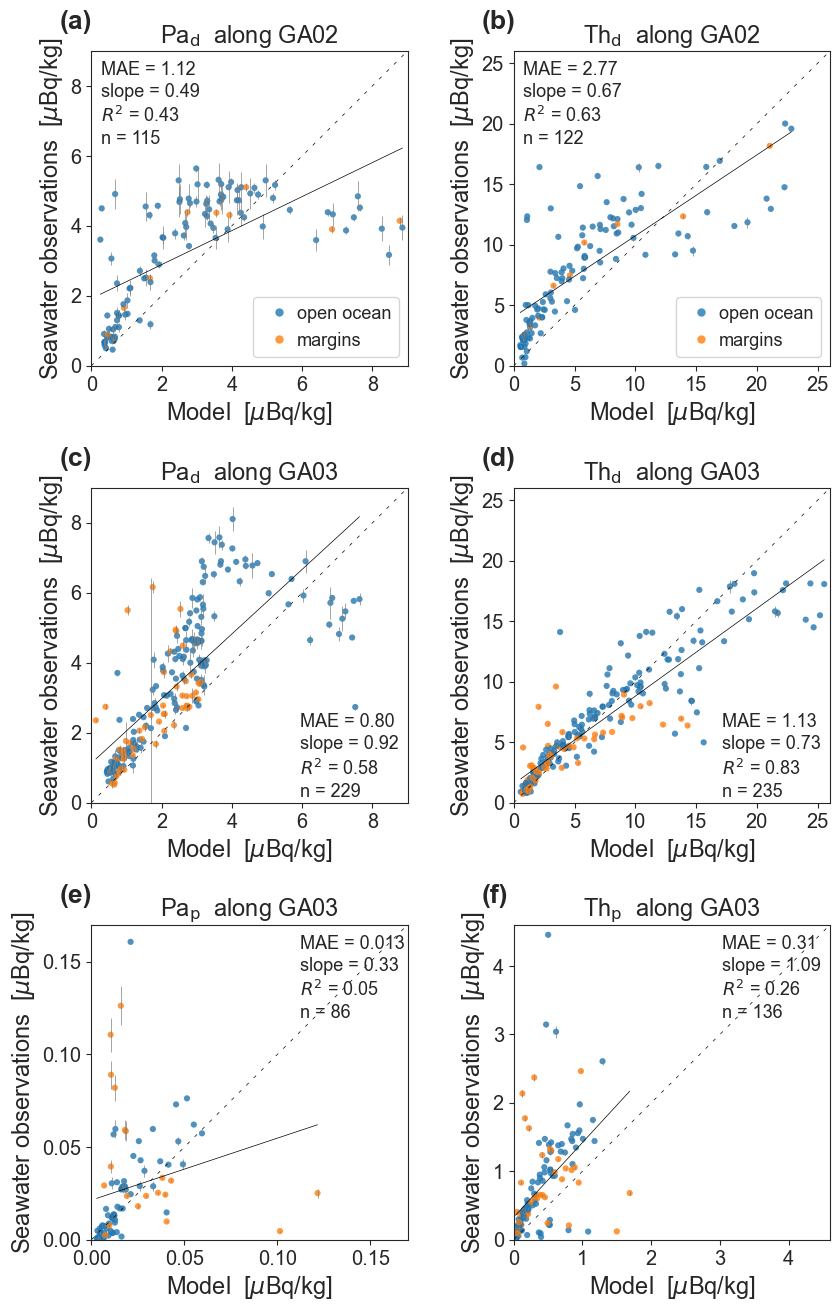

In [13]:
# combine scatter plots multi-panel (arranged as Fig. 5's panel configuration)

########### SETTINGS ########################################
run = ctrl
error_bars = True
plot_fit = True
# pick either of these:
highlight_margins = True    # bit slow
color_by_depth = False
color_by_latitude = False
color_by_longitude = False

size = 20             # marker size
this_cmap = 'Accent'  # Viridis or Accent (categories)
this_vmin = 0.0
vmaxs = {'Pad' : 9, 'Thd' : 26, 'Pap' : 0.17, 'Thp' : 4.6,
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}  # new, all points inside plot; especially Thp is zoomed out
# vmaxs = {'Pad' : 8, 'Thd' : 25, 'Pap' : 0.2, 'Thp' : 2,
#          'path_ratio_d' : 1, 'path_ratio_p' : 0.2} # old, same as in Fig. 5. SOME POINTS FALL OFF!
# vmaxs = {'Pad' : 8, 'Thd' : 25, 'Pap' : 0.17, 'Thp' : 2,
#          'path_ratio_d' : 1, 'path_ratio_p' : 0.2}  # old, as Fig. 5 but Pap lower because no vals >0.17. SOME POINTS FALL OFF!
########### END OF SETTINGS #################################
print('run = ',run)

assert np.sum([highlight_margins, color_by_depth, color_by_latitude, color_by_longitude]) <= 1, \
   "ERROR: only 1 of highlight_margins, color_by_depth, color_by_latitude, color_by_longitude can be True"

if color_by_depth or color_by_latitude or color_by_longitude:
   # make space for colorbars
   fig, ax = plt.subplots(3,2, figsize=(10,13.2))
else:
   fig, ax = plt.subplots(3,2, figsize=(8.5,13.2))

panel_nr = 0
for cruise in ['GA02', 'GA03']:  ## loop over GA02 GA03
   if cruise == 'GA02':
      this_cruise_variables = ['Pad', 'Thd']
   elif cruise == 'GA03':
      this_cruise_variables = ['Pad', 'Thd', 'Pap', 'Thp']
   else:
      raise Exception('unknown cruise variables')

   for i,variable in enumerate(this_cruise_variables):  ## loop over Pad etc
      if cruise == 'GA02':
         # use first 2 panels
         row = 0
         col = i%2
      elif cruise == 'GA03':
         # use panels 3-6
         row = int(i/2) + 1
         col = i%2

      if variable in ['Pad', 'Thd']:
         this_obs_ave = obs_d_ave[obs_d_ave.cruise==cruise].dropna(how='all')
      elif variable in ['Pap', 'Thp']:
         this_obs_ave = obs_p_ave[obs_p_ave.cruise==cruise].dropna(how='all')
      else:
         raise Exception('unknown variable')
      this_obs_ave = this_obs_ave[this_obs_ave[variable].notna()]  # only keep subset non-nan for this variable
      [this_res_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                               obs_ave=this_obs_ave, convert_unit_to_obs=True)
      model_data = this_res_table[variable]
      obs_data = this_obs_ave[variable]
      obs_data_err = this_obs_ave[variable+'_err']

      # convert obs_data from object to float Dataframe
      obs_data = pd.to_numeric(obs_data, errors='coerce')
      obs_data_err = pd.to_numeric(obs_data_err, errors='coerce')
      # print info
      assert len(obs_data) == len(model_data), "ERROR: unequal length of model and obs data"
      print('\nCRUISE:', cruise, 'VARIABLE:', variable)
      print('nr of data points:', len(obs_data))
      print('nr of non-nan data in model:', len(model_data[~np.isnan(model_data)]))
      print('nr of non-nan data in obs:', len(obs_data[~np.isnan(obs_data)]))

      # print warning+info if points fall out of the plot
      if model_data.max() > vmaxs[variable]:
         print('WARNING: points outside plot for', variable, 'in', cruise,' (model_data.max()=', model_data.max(),'>',vmaxs[variable],')')
      if obs_data.max() > vmaxs[variable]:
         print('WARNING: points outside plot for', variable, 'in', cruise,' (obs_data.max()=', obs_data.max(),'>',vmaxs[variable],')')

      # plot
      if highlight_margins:
         # loop over model_data/obs_data and check if they are in margin_cells_GA02_GA03
         for (lat,lon,z) in model_data.index:
            if (lon,lat) in margin_cells_GA02_GA03:
               ax[row,col].scatter(model_data.loc[(lat,lon,z)], obs_data.loc[(lat,lon,z)], s=size, alpha=0.8,
                                   facecolor='C1', edgecolor='none')  # hardcode same color at bottom in legend
            else:
               ax[row,col].scatter(model_data.loc[(lat,lon,z)], obs_data.loc[(lat,lon,z)], s=size, alpha=0.8, 
                                   facecolor='C0', edgecolor='none')  # make default facecolor blue C0 explicit      
      else:
         # no for loop needed
         if color_by_depth:
            if this_cmap == 'Accent':
               this_cmap = ListedColormap(matplotlib.colormaps.get_cmap('Accent').colors[:5]) # want 5 categories of 1 km each
            cpf = ax[row,col].scatter(model_data, obs_data, s=size, alpha=0.8, 
                                    c=obs_data.index.get_level_values(2), cmap=this_cmap, edgecolor='none')
            cbar = fig.colorbar(cpf, ax=ax[row,col], extend='neither')
         elif color_by_latitude:
            if this_cmap == 'Accent':
               # want categories from 50 S to 60 N; make it 60 S to 60 N in steps of 20, so 6 categories
               this_cmap = ListedColormap(matplotlib.colormaps.get_cmap('Accent').colors[:6])
            # cpf = ax[row,col].scatter(model_data, obs_data, s=size, alpha=0.8, vmin=-60, vmax=60, 
            cpf = ax[row,col].scatter(model_data, obs_data, s=size, alpha=0.8, vmin=-50, vmax=70,
                                     c=obs_data.index.get_level_values(0), cmap=this_cmap, edgecolor='none')
            cbar = fig.colorbar(cpf, ax=ax[row,col], extend='neither')
         elif color_by_longitude:
            cpf = ax[row,col].scatter(model_data, obs_data, s=size, alpha=0.8, 
                                     c=obs_data.index.get_level_values(1), cmap=this_cmap, edgecolor='none')
            cbar = fig.colorbar(cpf, ax=ax[row,col], extend='neither')
         else:
            ax[row,col].scatter(model_data, obs_data, s=size, alpha=0.8, edgecolor='none')

      if error_bars:
         ax[row,col].errorbar(model_data, obs_data, yerr=obs_data_err, fmt='none', ecolor='grey', lw=0.5)

      ## COMPUTE STATISTICS between model_data and obs_data
      ## A). compute slope, R2 and p-value in numpy
      # mask out nan values if model_data or obs_data is nan
      obs_data = obs_data[~np.isnan(model_data) & ~np.isnan(obs_data)]
      obs_data_err = obs_data_err[~np.isnan(model_data) & ~np.isnan(obs_data)]
      model_data = model_data[~np.isnan(model_data) & ~np.isnan(obs_data)]
      slope, intercept, r_value, p_value, std_err = stats.linregress(model_data, obs_data)

      ## B). compute MAE in pandas (functions need data in pandas)
      # mask out nan values if model_data or obs_data is nan (pandas)
      this_sw_obs_ave = this_obs_ave[this_res_table[variable].notna()] # only keep obs where model has values (i.e. not sediment/land)
      obs_data_pd = this_sw_obs_ave[variable].dropna(how='all')
      model_data_pd = this_res_table[variable].dropna(how='all')
      # find weights
      weights_found = f.find_weights(this_sw_obs_ave, res_entire, volume=False, uncertainty=True)      
      if variable[:-1] == 'Pa':
         [weights, junk] = weights_found # fnc outputs 2 objects for Pa and Th
      elif variable[:-1] == 'Th':
         [junk, weights] = weights_found # fnc outputs 2 objects for Pa and Th
      else:
         raise Exception('could not find weights for this unknown variable')
      # compute MAE
      this_MAE = f.calc_mae(model=model_data_pd, observation=obs_data_pd,
                            weights=weights, verbose=False)

      if plot_fit:
         # plot regression line for understanding of 'slope' variable
         fit_arr_x = np.linspace(model_data.min(), model_data.max(), 20)
         fit_arr_y = intercept + slope*fit_arr_x
         ax[row,col].plot(fit_arr_x, fit_arr_y, 'k', lw=0.5)

      # plot 1-to-1 line
      x_is_y_arr = np.linspace(this_vmin, vmaxs[variable], 5)
      ax[row,col].plot(x_is_y_arr, x_is_y_arr, 'k', ls='dashed', dashes=(5,10), lw=0.5)

      ## annotate statistics
      x_left = 0.03
      x_right = 0.66
      y_top = 0.925
      y_bottom = 0.24
      ## choose position of annotations here:
      if panel_nr == 4 or panel_nr == 5:
         (x0, y0) = (x_right, y_top)    # top right
      elif panel_nr == 2 or panel_nr == 3:
         (x0, y0) = (x_right, y_bottom) # bottom right
      else:
         (x0, y0) = (x_left, y_top)     # top left (default)

      if this_MAE < 0.1:
         MAE_str =  f'MAE = {this_MAE:.3f}'
      else:
         MAE_str =  f'MAE = {this_MAE:.2f}'
      ## define order of statistics to print
      statistics_to_print = [MAE_str,   # MAE is in uBq/kg
                             f'slope = {slope:.2f}',
                             f'$R^2$ = {r_value**2:.2f}',
                             f'n = {len(obs_data):.0f}'] 

      fs_stat = 13   # fontsize
      fs_labels = 17 # needs to go up because somehow got smaller because of smaller fs_stat
      ax[row,col].text(x0, y0, statistics_to_print[0], 
                       transform=ax[row,col].transAxes, fontsize=fs_stat)
      ax[row,col].text(x0, y0-0.07, statistics_to_print[1], 
                       transform=ax[row,col].transAxes, fontsize=fs_stat)
      ax[row,col].text(x0, y0-0.15, statistics_to_print[2],
                       transform=ax[row,col].transAxes, fontsize=fs_stat)
      ax[row,col].text(x0, y0-0.22, statistics_to_print[3],
                       transform=ax[row,col].transAxes, fontsize=fs_stat)

      # title, labels
      ax[row,col].set_title(variable.replace('p', '$\mathrm{_p}$').replace('d', '$\mathrm{_d}$') + '  along ' + cruise,
                            fontsize=fs_labels)
      ax[row,col].set_xlabel("Model  [$\mu$Bq/kg]", fontsize=fs_labels)
      ax[row,col].set_ylabel("Seawater observations  [$\mu$Bq/kg]", fontsize=fs_labels)
      ax[row,col].text(-0.1, 1.07, '(' + chr(ord('a')+panel_nr) + ')', transform=ax[row,col].transAxes, 
                       size=fs_labels+2, weight='bold')

      ax[row,col].set_xlim(this_vmin, vmaxs[variable])
      ax[row,col].set_ylim(this_vmin, vmaxs[variable])

      # make nice ticks depending on vmax
      if vmaxs[variable] < 1: # p-bound forms
         ticks = np.arange(0,vmaxs[variable]+0.01, 0.05)
      elif vmaxs[variable] < 5:
         ticks = np.arange(0,vmaxs[variable]+0.1, 1)
      elif vmaxs[variable] < 10:
         ticks = np.arange(0,vmaxs[variable]+0.1, 2)
      else:
         ticks = np.arange(0,vmaxs[variable]+0.1, 5)
      ax[row,col].set_xticks(ticks)
      ax[row,col].set_yticks(ticks)

      panel_nr += 1  # counter for a) b) etc

# add legend manually
if highlight_margins:
   handle_size = 6  # for some reason taking the same size as above makes them too large
   handles = [matplotlib.lines.Line2D([0], [0], linestyle='', marker='o', markersize=handle_size,
                                    alpha=0.8, markerfacecolor='C0', markeredgecolor='none'),
            matplotlib.lines.Line2D([0], [0], linestyle='', marker='o', markersize=handle_size,
                                    alpha=0.8, markerfacecolor='C1', markeredgecolor='none')]
   marker_labels = ['open ocean', 'margins']
   for col in [0,1]:
      ax[0,col].legend(handles, marker_labels, loc='lower right', fontsize=fs_stat, handletextpad=0.0)

plt.tight_layout(h_pad=1.5, w_pad=3)

filename_suffix = ''
if highlight_margins:
   filename_suffix = '_margins_red'
elif color_by_depth:
   filename_suffix = '_depth'
elif color_by_latitude:
   filename_suffix = '_lat'
elif color_by_longitude:
   filename_suffix = '_lon'

plt.savefig(savedir / ('fig6_scatter'+filename_suffix+'.pdf'))
# plt.savefig(savedir / ('fig6_scatter'+filename_suffix+'.png'), dpi=300)

In [14]:
# What are R2 and MAE without margins? This is expected to improve Pap and Thp (it does)

for cruise in ['GA02', 'GA03']:  ## loop over GA02 GA03
   if cruise == 'GA02':
      this_cruise_variables = ['Pad', 'Thd']
   elif cruise == 'GA03':
      this_cruise_variables = ['Pad', 'Thd', 'Pap', 'Thp']
   else:
      raise Exception('unknown cruise variables')

   for i,variable in enumerate(this_cruise_variables):  ## loop over Pad etc
      print('cruise:', cruise, 'variable:', variable)

      if variable in ['Pad', 'Thd']:
         this_obs_ave = obs_d_ave[obs_d_ave.cruise==cruise].dropna(how='all')
      elif variable in ['Pap', 'Thp']:
         this_obs_ave = obs_p_ave[obs_p_ave.cruise==cruise].dropna(how='all')
      else:
         raise Exception('unknown variable')
      this_obs_ave = this_obs_ave[this_obs_ave[variable].notna()]  # only keep subset non-nan for this variable
      [this_res_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                               obs_ave=this_obs_ave, convert_unit_to_obs=True)
      this_obs_ave = this_obs_ave[this_res_table[variable].notna()] # only keep obs where model has values (i.e. not sediment/land)
      model_data = this_res_table[variable]
      obs_data = this_obs_ave[variable]
      obs_data_err = this_obs_ave[variable+'_err']

      # convert obs_data from object to float Dataframe
      obs_data = pd.to_numeric(obs_data, errors='coerce')
      obs_data_err = pd.to_numeric(obs_data_err, errors='coerce')

      # MAKE ARRAY WITH ALL DATA POINTS THAT ARE NOT IN margin_cells_GA02_GA03
      model_data_no_margins = []
      obs_data_no_margins = []
      obs_data_err_no_margins = []
      lat_no_margins = []
      lon_no_margins = []
      z_no_margins = []
      this_obs_ave_no_margins = this_obs_ave.copy(deep=True)
      # loop over model_data/obs_data and check if they are in margin_cells_GA02_GA03
      for (lat,lon,z) in model_data.index:
         if (lon,lat) in margin_cells_GA02_GA03:
            # drop those rows from this_obs_ave_no_margins
            this_obs_ave_no_margins = this_obs_ave_no_margins[~((this_obs_ave_no_margins.index.get_level_values(0)==lat) & 
                                                                (this_obs_ave_no_margins.index.get_level_values(1)==lon))]
            continue
         elif np.isnan(model_data.loc[(lat,lon,z)]) or np.isnan(obs_data.loc[(lat,lon,z)]):
            continue
         else:
            model_data_no_margins.append(model_data.loc[(lat,lon,z)])
            obs_data_no_margins.append(obs_data.loc[(lat,lon,z)])
            obs_data_err_no_margins.append(obs_data_err.loc[(lat,lon,z)])
            lat_no_margins.append(lat)
            lon_no_margins.append(lon)
            z_no_margins.append(z)
      # use model_data_no_margins, obs_data_no_margins directly for A). slope, r2, p-value calculation
      # create pandas Dataframe for model_data_no_margins for B). MAE calculation (also uses this_obs_ave_no_margins)
      multi_index = pd.MultiIndex.from_tuples(list(zip(lat_no_margins, lon_no_margins, z_no_margins)),
                                             names=["lat_sim", "lon_sim_100_to_460", "z_sim"])
      this_model_data_no_margins = pd.DataFrame({variable: model_data_no_margins},
                                                index=multi_index)

      ## COMPUTE STATISTICS between model_data and obs_data
      ## A). compute slope, R2 and p-value in numpy
      slope, intercept, r_value, p_value, std_err = stats.linregress(model_data_no_margins, obs_data_no_margins)
      print('R2 =', r_value**2)
      print('slope =', slope)
      print('n =', len(obs_data_no_margins))

      ## B). compute MAE in pandas (functions need data in pandas)
      # find weights; expects this_obs_ave_no_margins to have both Pa and Th columns (constructed like this above)
      weights_found = f.find_weights(this_obs_ave_no_margins, res_entire, volume=False, uncertainty=True)
      if variable[:-1] == 'Pa':
         [weights, junk] = weights_found # fnc outputs 2 objects for Pa and Th
      elif variable[:-1] == 'Th':
         [junk, weights] = weights_found # fnc outputs 2 objects for Pa and Th
      else:
         raise Exception('could not find weights for this unknown variable')
      # compute MAE
      obs_data_pd = this_obs_ave_no_margins[variable].dropna(how='all')
      model_data_pd = this_model_data_no_margins[variable].dropna(how='all')
      this_MAE = f.calc_mae(model=model_data_pd, observation=obs_data_pd,
                            weights=weights, verbose=False)
      print('MAE =', this_MAE)
      print('n =', len(obs_data_no_margins),'\n')  # print again as check; should be identical to above

cruise: GA02 variable: Pad
R2 = 0.4417017700632525
slope = 0.5080838683566401
n = 106
MAE = 1.0842652127212633
n = 106 

cruise: GA02 variable: Thd
R2 = 0.6037815170250463
slope = 0.6635133402881322
n = 113
MAE = 2.774340102651628
n = 113 

cruise: GA03 variable: Pad
R2 = 0.5793556655330093
slope = 0.8865153477606044
n = 168
MAE = 0.9361835830021695
n = 168 

cruise: GA03 variable: Thd
R2 = 0.8365345858153307
slope = 0.7324184161611165
n = 173
MAE = 1.0930042822023236
n = 173 

cruise: GA03 variable: Pap
R2 = 0.38953794973144495
slope = 1.1794872862220698
n = 66
MAE = 0.008941739423125749
n = 66 

cruise: GA03 variable: Thp
R2 = 0.4395146645796415
slope = 1.583178949700615
n = 100
MAE = 0.27976506903966075
n = 100 



# Fig. 7: Bottom Pap/Thp

In [15]:
## PREPARATION
# ADD path_ratio_p_bottom for this run to its data_fulls; ALSO compute bottom depth in meters in 'bottom_m' (independent of run)

########### SETTINGS ########################################
run = ctrl
#############################################################

# initialize obj to save bottom depth in meter; for bottom_m which run doesn't matter
bottom_m = xr.DataArray(data=np.zeros((40,41)),
                        dims=['lat_t', 'lon_t'],
                        coords={'lon_t': (['lon_t'], data_fulls[run].lon_t.data,
                                          {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                'lat_t': (['lat_t'], data_fulls[run].lat_t.data,
                                          {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})
print('run = ',run)
print("timestep: t=",t, '\n')

full_obj = data_fulls[run]

# we compute Pap/Thp in the bottommost cell & bottom depth of the ocean in meters
# this is adapted from a copy of the intermezzo under 'Particle fields' without the nr_neph_cells part

# initialize with 0s
path_ratio_p_bottom = xr.DataArray(data=np.zeros((40,41)),
                                   dims=['lat_t', 'lon_t'],
                                   coords={'lon_t': (['lon_t'], full_obj.lon_t.data,
                                              {'units': "degrees_east", 'long_name': "Longitude", 
                                              'standard_name': "longitude", 'axis': "X"}),
                                           'lat_t': (['lat_t'], full_obj.lat_t.data,
                                              {'units': "degrees_north", 'long_name': "Latitude", 
                                              'standard_name': "latitude", 'axis': "Y"})})
for lat in range(len(full_obj.lat_t)):
      for lon in range(len(full_obj.lon_t)):
            ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
            # find 1st z_t index hitting land/sediment; using that mask is 0 where land or sediment
            try:
                  z_t_index_sed = np.where(full_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
                  # z_t_index_sed = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
            except:
                  # 0 is not in the list => water column has maximal depth of 32 grid cells, so sediment is hypothetically the 33th cell, i=32
                  z_t_index_sed = 32
                  
            # the upper boundary of the z_t_index_sed cell is bottom_m in km. This is the same index in z_w
            this_z_bottom = full_obj.z_w[z_t_index_sed] * 1000  # z_w in km; convert to m
            if this_z_bottom > 0.0:  # otherwise already initialized as 0
                  bottom_m[lat,lon] = this_z_bottom  # INDEPENT OF RUN

            ## FIND PAP/THP AT BOTTOM AND SAVE IN path_ratio_p_bottom
            # model has nan values at sediment cell so we need to go 1 cell up to get the bottommost water cell
            if z_t_index_sed == 0:
                  path_ratio_p_bottom[lat,lon] = np.nan  # no ocean here 
            else:
                  path_ratio_p_bottom[lat,lon] = full_obj.path_ratio_p.isel(time=t, lat_t=lat, lon_t=lon, z_t=z_t_index_sed - 1)

# save results for this run
data_fulls[run]['path_ratio_p_bottom'] = path_ratio_p_bottom
    
print('path_ratio_p_bottom variables are added to data_fulls for run',run)

run =  CTRL_NEWNR
timestep: t= -1 

path_ratio_p_bottom variables are added to data_fulls for run CTRL_NEWNR


run =  CTRL_NEWNR

panel a)
nr of data points: 104

panel b)
nr of data points: 104
nr of non-nan data in model: 74


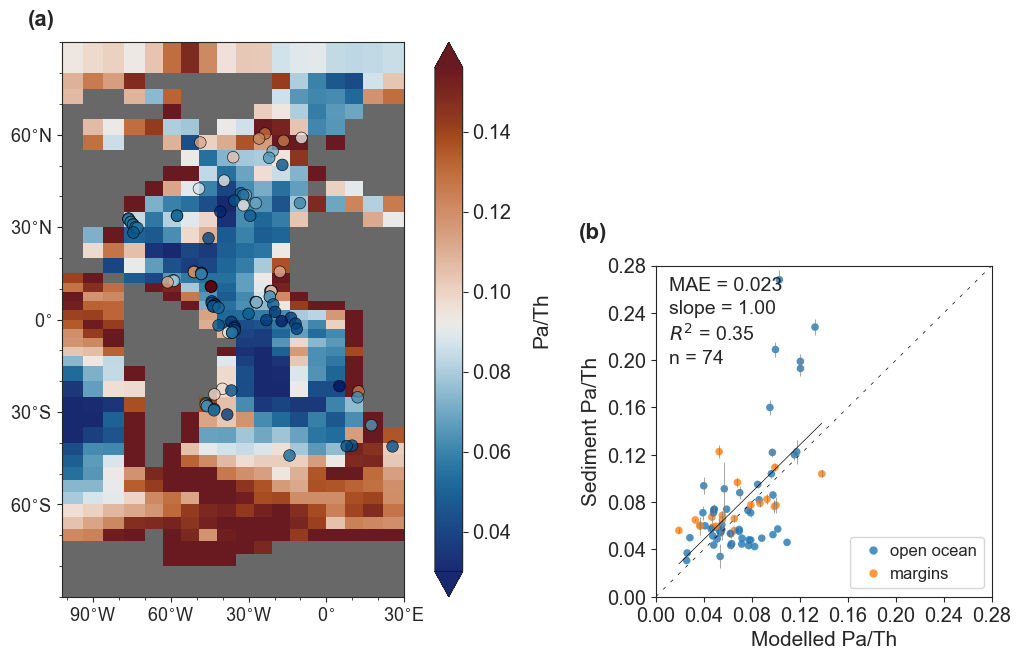

In [16]:
# combine Fig. 7a and 7b of Pap/Thp bottom in one figure

########### SETTINGS ########################################
run = ctrl
########### SETTINGS FIG. 7A ################################
# always using zoom_atl
alpha_model = 0.9  # transparency
alpha_obs = 0.8    # transparency
size_panel_a = 70          # marker size for obs
cmap_panel_a = cmcr.vik
# choose vmin and vmax s.t. production ratio 0.093 is in the middle:
vmin = 0.03
vmax = 0.156
########### SETTINGS FIG. 7B ################################
error_bars = True
plot_fit = True

# pick either of these:
highlight_margins = True
color_by_depth = False
color_by_latitude = False
color_by_longitude = False
color_by_delta_z = False  # not useful for Fig. 7a, says nothing about that

add_core_nr = False        # annotate core nr next to marker
plot_only_core_nr = False  # plot core nr instead of marker (lower left of nr is exactly at the right position)
spacing_core_nr = 0.002   # only used for add_core_nr, not for plot_only_core_nr
fontsize_core_nr = 10

size_panel_b = 30              # marker size
cmap_panel_b = 'Accent'   # viridis or Accent (categorical)
min_val = 0.0          # axis limits (same for x and y)
max_val = 0.28         # 0.15 (as panel a; cuts off cores) or 0.28 (plots all cores) or 0.09 (zoom in to read core_nrs)
########### END OF SETTINGS #################################

full_obj = data_fulls[run]
print('run = ',run)

assert np.sum([highlight_margins, color_by_depth, color_by_latitude, color_by_longitude, color_by_delta_z]) <= 1, \
   "ERROR: only 1 of highlight_margins, color_by_depth, color_by_latitude, color_by_longitude, color_by_delta_z can be True"

assert np.sum([add_core_nr, plot_only_core_nr]) <= 1, "ERROR: only 1 of add_core_nr, plot_only_core_nr can be True"

####### CREATE FIGURE #######
sns.set_style('ticks')

# fig = plt.figure(figsize=(10, 6))  # results in too large fontsize
# fig = plt.figure(figsize=(15, 9))  # results in too small fontsize  
fig = plt.figure(figsize=(12, 7.2))  # nice 

# define a GridSpec layout with relative proportions s.t. panel a) larger and higher than panel b); panel b) stays square
gs = GridSpec(2, 2, height_ratios=[4.55, 6.75], width_ratios=[9.4, 7.2], hspace=0, wspace=0.4)

####### PLOT FIG 7A #######
ax_a = fig.add_subplot(gs[:, 0])

X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner
Z = full_obj.path_ratio_p_bottom.values
cpf = ax_a.pcolormesh(X, Y, Z, cmap=cmap_panel_a, alpha=alpha_model, vmin=vmin, vmax=vmax)
# nice cmaps: Dark2, Set2, Accent, Spectral_r, copper 
cbar = fig.colorbar(cpf, ax=ax_a, extend='both', pad=0.07)
cbar.set_label(label='Pa/Th', fontsize=15, labelpad=15)

ax_a.pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.25) # add land

# TITLE, TICKS
ax_a.set_yticks(range(-60,70,30))
ax_a.set_xticks([270,300,330,360,390])
ax_a.set_xticklabels([-90,-60,-30,0,30])        
ax_a.xaxis.set_minor_locator(MultipleLocator(10))
ax_a.yaxis.set_minor_locator(MultipleLocator(10))
ax_a.set_xlim(258,390)

# add '°W' etc
ax_a = f.convert_ticks_of_map(ax_a, Bern3D_grid=True)
ax_a.tick_params(axis='x', labelsize=13)
ax_a.tick_params(axis='y', labelsize=13)

# ADD SEDIMENT OBSERVATIONS
this_obs_sed = obs_sed
print('\npanel a)\nnr of data points:', len(this_obs_sed))
ax_a.scatter(x=this_obs_sed.lon, y=this_obs_sed.lat, c=this_obs_sed.path_ratio_p, 
             marker='o', s=size_panel_a, lw=0.5, edgecolor='k', alpha=alpha_obs,
             cmap=cmap_panel_a, vmin=vmin, vmax=vmax)


####### PLOT FIG 7B #######
ax_b = fig.add_subplot(gs[1, 1])

this_obs_sed = obs_sed_model_grid
# make coord order from obs_sed_model_grid consistent with what get_sim() expects
this_obs_sed = this_obs_sed.reset_index().set_index(['lat_sim', 'lon_sim_100_to_460', 'z_sim'], inplace=False)
this_obs_sed.sort_index(inplace=True)

[res_p_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                      obs_ave=this_obs_sed, convert_unit_to_obs=True)
res_p_table['path_ratio_p'] = res_p_table.Pap / res_p_table.Thp
model_data = res_p_table.path_ratio_p
obs_data = this_obs_sed.path_ratio_p
obs_data_err = this_obs_sed.path_ratio_p_err
obs_data_delta_z = this_obs_sed.delta_z
obs_data_nr = this_obs_sed['#']
obs_data_lon = this_obs_sed.lon
obs_data_lat = this_obs_sed.lat

assert len(obs_data) == len(model_data), "ERROR: unequal length of model and obs data"
print('\npanel b)\nnr of data points:', len(obs_data))
print('nr of non-nan data in model:', len(model_data[~np.isnan(model_data)]))

# mask out nan values: do not consider if model_data is nan 
# (model is nan if sediment core deeper than model bottom; obs_data is never nan)
obs_data = obs_data[~np.isnan(model_data)]
obs_data_err = obs_data_err[~np.isnan(model_data)]
obs_data_delta_z = obs_data_delta_z[~np.isnan(model_data)]
obs_data_nr = obs_data_nr[~np.isnan(model_data)]
obs_data_lon = obs_data_lon[~np.isnan(model_data)]
obs_data_lat = obs_data_lat[~np.isnan(model_data)]
model_data = model_data[~np.isnan(model_data)]
# convert obs_data from object to float Dataframe
obs_data = pd.to_numeric(obs_data, errors='coerce')
obs_data_err = pd.to_numeric(obs_data_err, errors='coerce')
obs_data_delta_z = pd.to_numeric(obs_data_delta_z, errors='coerce')
obs_data_nr = pd.to_numeric(obs_data_nr, errors='coerce')
obs_data_lon = pd.to_numeric(obs_data_lon, errors='coerce')
obs_data_lat = pd.to_numeric(obs_data_lat, errors='coerce')

# print warning+info if points fall out of the plot
if model_data.max() > max_val:
   print('WARNING: points outside plot because model_data.max()=', model_data.max(),'>',max_val,'\n')
if obs_data.max() > max_val:
   print('WARNING: points outside plot because obs_data.max()=', obs_data.max(),'>',max_val,'\n')

# plot
if plot_only_core_nr:
   # plot core numbers instead of markers
   for i,core_nr in enumerate(obs_data_nr.values):  # for loop has same structure as above in case of highlight_margins
      this_obs_data = obs_data.values[i]
      if this_obs_data > max_val:
         print('core_nr', core_nr, 'not plotted because has obs_data', this_obs_data, 'which is higher than max_val', max_val)
      else:
         # find model_data for this core nr via coords (maybe model_data.values[i] is equivalent but just to be sure)
         (lat,lon,z) = obs_data_nr.index[obs_data_nr.values == core_nr][0]  
         this_model_data = model_data.loc[(lat,lon,z)]
         if len(this_model_data) == 1:
            this_model_data = this_model_data.item()
         elif len(this_model_data) > 1:
            # if multiple obs in same cell, then >1 item with this coord in model_data (all items identical)
            this_model_data = this_model_data.values[0]
         if this_model_data > max_val:
            print('core_nr', core_nr, 'not plotted because has model_data', this_model_data, 'which is higher than max_val', max_val)
         else:
            # plot this core_nr
            ax_b.text(this_model_data, this_obs_data, str(core_nr), fontsize=fontsize_core_nr)
else:
   # plot markers
   if highlight_margins:
      for i,core_nr in enumerate(obs_data_nr.values):
         this_obs_data = obs_data.values[i]
         # find model_data for this core nr via coords (maybe model_data.values[i] is equivalent but just to be sure)
         (lat,lon,z) = obs_data_nr.index[obs_data_nr.values == core_nr][0]  # used to find model_data
         this_model_data = model_data.loc[(lat,lon,z)]
         if len(this_model_data) > 1:
            # if multiple obs in same cell, then >1 item with this coord in model_data (all items identical)
            this_model_data = this_model_data.values[0]  
         if core_nr in margin_cells_sed:
            ax_b.scatter(this_model_data, this_obs_data, s=size_panel_b, alpha=0.8,
                           facecolor='C1', edgecolor='none')  # hardcode same color at bottom in legend
         else:
            ax_b.scatter(this_model_data, this_obs_data, s=size_panel_b, alpha=0.8, 
                           facecolor='C0', edgecolor='none')  # make default facecolor blue C0 explicit
   else:
      # no for loop needed
      if color_by_depth:
         if cmap_panel_b == 'Accent':
            cmap_panel_b = ListedColormap(matplotlib.colormaps.get_cmap('Accent').colors[:5]) # want 5 categories of 1 km each
         cpf = ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, vmin=0, vmax=5000,
                           c=obs_data.index.get_level_values(2), cmap=cmap_panel_b, edgecolor='none')
         cbar = fig.colorbar(cpf, ax=ax_b, extend='neither')
      elif color_by_latitude:
         if cmap_panel_b == 'Accent':
            # want categories from 50 S to 60 N; make it 60 S to 60 N in steps of 20, so 6 categories
            cmap_panel_b = ListedColormap(matplotlib.colormaps.get_cmap('Accent').colors[:6]) 
         # cpf = ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, vmin=-50, vmax=70,
         cpf = ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, vmin=-60, vmax=60,
                           c=obs_data.index.get_level_values(0), cmap=cmap_panel_b, edgecolor='none')
         cbar = fig.colorbar(cpf, ax=ax_b, extend='neither')
      elif color_by_longitude:
         cpf = ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, 
                           c=obs_data.index.get_level_values(1), cmap=cmap_panel_b, edgecolor='none')
         cbar = fig.colorbar(cpf, ax=ax_b, extend='neither')
      elif color_by_delta_z:
         cpf = ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, 
                           c=obs_data_delta_z, cmap='coolwarm', vmin=-200, vmax=200, edgecolor='none') # max at 310
         cbar = fig.colorbar(cpf, ax=ax_b, extend='neither')
      else:
         ax_b.scatter(model_data, obs_data, s=size_panel_b, alpha=0.8, edgecolor='none')

   # ANNOTATE CORE NUMBERS NEXT TO MARKERS
   if add_core_nr:
      for i,core_nr in enumerate(obs_data_nr.values):  # for loop has same structure as above in case of highlight_margins
         this_obs_data = obs_data.values[i]
         if this_obs_data > max_val:
            print('core_nr', core_nr, 'not plotted because has obs_data', this_obs_data, 'which is higher than max_val', max_val)
         else:
            # find model_data for this core nr via coords (maybe model_data.values[i] is equivalent but just to be sure)
            (lat,lon,z) = obs_data_nr.index[obs_data_nr.values == core_nr][0]  
            this_model_data = model_data.loc[(lat,lon,z)]
            if len(this_model_data) == 1:
               this_model_data = this_model_data.item()
            elif len(this_model_data) > 1:
               # if multiple obs in same cell, then >1 item with this coord in model_data (all items identical)
               this_model_data = this_model_data.values[0]
            if this_model_data > max_val:
               print('core_nr', core_nr, 'not plotted because has model_data', this_model_data, 'which is higher than max_val', max_val)
            else:
               # annotate this core_nr
               ax_b.text(this_model_data + spacing_core_nr, this_obs_data + spacing_core_nr, str(core_nr), fontsize=fontsize_core_nr)

   if error_bars:
      ax_b.errorbar(model_data, obs_data, yerr=obs_data_err, fmt='none', ecolor='grey', lw=0.5)
      
ax_b.set_xlabel('Modelled Pa/Th', fontsize=15) # dont understand why suddenly font gets small
ax_b.set_ylabel('Sediment Pa/Th', fontsize=15)

## COMPUTE STATISTICS between model_data and obs_data
## A). compute slope, R2 and p-value in numpy
# mask out nan values if model_data or obs_data is nan (numpy) => already done above
slope, intercept, r_value, p_value, std_err = stats.linregress(model_data, obs_data)

## B). compute MAE in pandas (functions need data in pandas)
# mask out nan values if model_data or obs_data is nan (pandas)
this_obs_sed_MAE = this_obs_sed[res_p_table['path_ratio_p'].notna()] # only keep obs where model has values (i.e. not sediment/land)
obs_data_pd = this_obs_sed_MAE['path_ratio_p'].dropna(how='all')
model_data_pd = res_p_table['path_ratio_p'].dropna(how='all')
# find weights; fnc only outputs 1 object for path_ratio_p
weights = f.find_weights(this_obs_sed_MAE, res_entire, volume=False, uncertainty=True)
# compute MAE
this_MAE = f.calc_mae(model=model_data_pd, observation=obs_data_pd,
                      weights=weights, verbose=False)

if plot_fit:
   # plot regression line for understanding of 'slope' variable
   fit_arr_x = np.linspace(model_data.min(), model_data.max(), 20)
   fit_arr_y = intercept + slope*fit_arr_x
   ax_b.plot(fit_arr_x, fit_arr_y, 'k', lw=0.5)

# plot 1-to-1 line
x_is_y_arr = np.linspace(min_val, max_val, 5)
ax_b.plot(x_is_y_arr, x_is_y_arr, 'k', ls='dashed', dashes=(5,10), lw=0.5)

## annotate statistics
## choose position of annotations here:
(x0,y0) = (0.04,0.925)  # top left
# (x0,y0) = (0.68,0.26) # bottom right

if this_MAE < 0.1:
   MAE_str =  f'MAE = {this_MAE:.3f}'
else:
   MAE_str =  f'MAE = {this_MAE:.2f}'
## define order of statistics to print
statistics_to_print = [MAE_str,   # MAE is in uBq/kg
                       f'slope = {slope:.2f}',
                       f'$R^2$ = {r_value**2:.2f}',
                       f'n = {len(obs_data):.0f}'] 

ax_b.text(x0, y0, statistics_to_print[0], 
           transform=ax_b.transAxes, fontsize=14)
ax_b.text(x0, y0-0.07, statistics_to_print[1], 
           transform=ax_b.transAxes, fontsize=14)
ax_b.text(x0, y0-0.15, statistics_to_print[2],
           transform=ax_b.transAxes, fontsize=14)
ax_b.text(x0, y0-0.22, statistics_to_print[3],
           transform=ax_b.transAxes, fontsize=14)

ax_b.set_xlim(min_val, max_val)
ax_b.set_ylim(min_val, max_val)
ticks = np.arange(0,max_val+0.005, 0.04)
ax_b.set_xticks(ticks)
ax_b.set_yticks(ticks)

# (a), (b)
ax_a.text(-0.1, 1.03, '(a)', transform=ax_a.transAxes, size=16, weight='bold')
ax_b.text(-0.23, 1.08, '(b)', transform=ax_b.transAxes, size=16, weight='bold')

# add legend manually
if highlight_margins:
   handle_size = 6  # for some reason taking the same size as above makes them too large
   handles = [matplotlib.lines.Line2D([0], [0], linestyle='', marker='o', markersize=handle_size, 
                                    alpha=0.8, markerfacecolor='C0', markeredgecolor='none'),
            matplotlib.lines.Line2D([0], [0], linestyle='', marker='o', markersize=handle_size, 
                                    alpha=0.8, markerfacecolor='C1', markeredgecolor='none')]
   marker_labels = ['open ocean', 'margins']
   ax_b.legend(handles, marker_labels, loc='lower right', fontsize=12, handletextpad=0.0)

# Turn off the axis for unused panels
ax_unused = fig.add_subplot(gs[0,1]) # manually adjust based on ax_a and ax_b
ax_unused.axis("off")

filename_suffix = ''
if highlight_margins:
   filename_suffix = '_margins_red'
elif color_by_depth:
   filename_suffix = '_depth'
elif color_by_latitude:
   filename_suffix = '_lat'
elif color_by_longitude:
   filename_suffix = '_lon'
elif color_by_delta_z:
   filename_suffix = '_delta_z'

plt.savefig(savedir / ('fig7ab_PapThp_bottom_run_' + run + filename_suffix + '.pdf'))
# plt.savefig(savedir / ('fig7ab_PapThp_bottom_run_' + run + filename_suffix + '.png'), dpi=300)

# Pa export and budget
Procedure is described in Supplementary Text S4.  
Supplementary Tables S1 & S2 contain the results computed below.  
Fig. C4, 8, 9 and S8 are made based on this.  

The following contains: 
- plotting of subbasin definitions (Fig. C4)
- computations for Fig. 8 and Tables S1-S2
- computations for Fig. 9 & S8 and making the figures  

Here we follow the study by Deng et al.:

   - Deng, F., Henderson, G. M., Castrillejo, M., Perez, F. F. and Steinfeldt, R. Evolution of 231Pa and 230Th in overflow waters of the North Atlantic. Biogeosciences, 2018, https://doi.org/10.5194/bg-15-7299-2018

**Define masks according to Deng et al. NAtl and SAtl**

In [17]:
# Make masks for SAtl, NAtl and entire Atl
## CORRECT VERSION WITH S Atl South boundary with a bend towards South Africa as it is in Deng 2014

## fill masks with the entire region of NAtl an SAtl
# fill mask_NAtl_Deng and mask_SAtl_Deng with 1 where mask lies in desired 3D region; -1 elsewhere and 0 in land/sediment
# approximation of GEOVIDE on Bern3D grid; list of grid cells (python indices) from north of 40N up to GEOVIDE:
# IF CHANGED: NEED TO CHANGE THE OBJECTS ABOVE AS WELL (cell_inside_N_bnd_Tgrid etc.)
top_of_NAtl_list = [(23,34),(24,34),(25,34),
                    (22,33),(23,33,),(24,33),(25,33),
                    (21,32),(22,32),(23,32),(24,32),(25,32),(26,32),
                    (20,31),(21,31),(22,31),(23,31),(24,31),(25,31),(26,31),(27,31)]

# SOUTHERN TRANSECT (WOCE A11) on Bern3D grid: 
# list of grid cells (python indices) to include that lie south of 30S
bottom_of_SAtl_list = [        (22,12),(23,12),(24,12),(25,12),(26,12),(27,12),(28,12),(29,12),(30,12),(31,12),
                               (22,11),(23,11),(24,11),(25,11),(26,11),(27,11),(28,11),(29,11),
                       (21,10),(22,10),(23,10),(24,10),(25,10),(26,10),(27,10),(28,10)]

run = ctrl  # run doesn't matter (only used for grid)
full_obj = data_fulls[run]
mask_NAtl_Deng = full_obj.masks.copy(deep=True)
mask_SAtl_Deng = full_obj.masks.copy(deep=True)
mask_entire_Atl_Deng = full_obj.masks.copy(deep=True)
for i,lon in enumerate(full_obj.lon_t):
    for j,lat in enumerate(full_obj.lat_t):
        if full_obj.masks.isel(lon_t=i, lat_t=j, z_t=0) == 1.0:
            # Atlantic basin=1
            if (i,j) in bottom_of_SAtl_list:
                # South Atlantic part 1: south of 30S with southern boundary following WOCE line A11 on Bern3D grid
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32
                mask_SAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values       # fills with 1; still 0 in sediment
                mask_entire_Atl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values # fills with 1; still 0 in sediment
            elif lat < -6.0 and lat > -30.0 and lon < 382.0:
                # South Atlantic part 2: north of 30S, taken W to E entirely, with upper u-grid boundary 6S (Deng: 4.5 S)
                # and 382.0 (taking 1 column less south of Africa)
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32                                        # order z, lat, lon
                mask_SAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values       # fills with 1; still 0 in sediment
                mask_entire_Atl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values # fills with 1; still 0 in sediment
            elif (lat > -6.0 and lat < 40) or ((i,j) in top_of_NAtl_list):
                # North Atlantic with u-grid boundary 6S and GEOVIDE converted onto Bern3D grid
                mask_NAtl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values       # fills with 1; still 0 in sediment
                mask_SAtl_Deng[:,j,i] = [-1.0] * 32
                mask_entire_Atl_Deng[:,j,i] = full_obj.masks.isel(lon_t=i, lat_t=j).values # fills with 1; still 0 in sediment
            else:
                # outside interesting part of Atlantic
                mask_NAtl_Deng[:,j,i] = [-1.0] * 32
                mask_SAtl_Deng[:,j,i] = [-1.0] * 32
                mask_entire_Atl_Deng[:,j,i] = [-1.0] * 32
        elif full_obj.masks.isel(lon_t=i, lat_t=j, z_t=0) == 0.0:
            # land: set value to 0 instead of -1 such that plots more visible
            mask_NAtl_Deng[:,j,i] = [0.0] * 32
            mask_SAtl_Deng[:,j,i] = [0.0] * 32
            mask_entire_Atl_Deng[:,j,i] = [0.0] * 32
        else:
            # not in Atlantic basin
            mask_NAtl_Deng[:,j,i] = [-1.0] * 32
            mask_SAtl_Deng[:,j,i] = [-1.0] * 32
            mask_entire_Atl_Deng[:,j,i] = [-1.0] * 32

## Fig. C4: boundaries of NAtl and SAtl definition

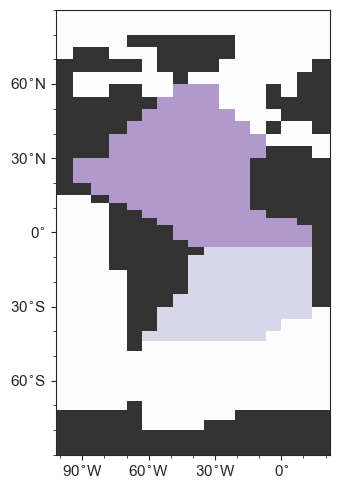

In [18]:
# plot sub-basin definitions

sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(3.5,5))

full_obj = data_fulls[run]  # only used for grid
X,Y = np.meshgrid(full_obj.lon_u, full_obj.lat_u) # u grid because pcolor needs left bottom corner

Z = (0.5 * mask_SAtl_Deng.isel(z_t=0) + mask_NAtl_Deng.isel(z_t=0)).values
cpf = ax.pcolormesh(X, Y, Z, cmap='Purples', alpha=0.4)#, vmin=-0.5, vmax=1.0)  

# fig.colorbar(cpf, ax=ax, extend='max')

ax.pcolormesh(X, Y, land_mask[2].values, cmap='Greys', vmin=-0.5, vmax=0.1) # add black land
ax.set_yticks(range(-60,70,30))
ax.set_xticks([270,300,330,360,390])
ax.set_xticklabels([-90,-60,-30,0,30])
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_xlim(258,382)

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.savefig(savedir / ('figC4_before_edit_NAtl_SAtl_boundaries_wo_transects.pdf'))
plt.show()

Transect lines are added manually on top in **figC4_NAtl_SAtl_boundaries.pptx**

## Fig. 8: budget
Fig. 8 is based on Deng et al. and made manually **in powerpoint (see attached file: fig8_PaTh_budget.pptx). Numbers needed for the figure are computed here.**   
This figure is similar to Deng et al. 2018, Biogeosciences, Fig. 11. Note that they do not write in that figure the amount of removal to the sediment (Table S4), since that follows directly from production and net advection.  

Reference for Deng et al.:

   - Deng, F., Henderson, G. M., Castrillejo, M., Perez, F. F. and Steinfeldt, R. Evolution of 231Pa and 230Th in overflow waters of the North Atlantic. Biogeosciences, 2018, https://doi.org/10.5194/bg-15-7299-2018  

We estimate in the same 2 regions the terms of the budget in our case. For the transport fluxes, we don't care about dissolved vs. particle-bound parts but we consider the total. Of course, only the particle-bound form sinks to the sediment.  

**Compute each term of the Pa and Th budget in this NAtl and SAtl region**   
1. production (Ad)  
2. transport with circulation via advection (Ad; neglecting Ap)  
3. removal to sediment (Ap)  
4. radioactive decay (Ad and Ap) => negligible so not used  
5. residual => is total production (1) minus the other processes (2 and 3).   
Represents horizontal diffusion of Pa & Th due to: gradients in Pa & Th plus model uncertainty  

N.B. scavenging => can be ignored since it is only an exchange between Ad and Ap

In [19]:
########### SETTINGS ##################################
run = ctrl
########### END OF SETTINGS ###########################

full_obj = data_fulls[run].isel(time=t)
print('run = ',run)
print("timestep: t=",t,'is', round(data_fulls[run].time[t].item()),'yr\n')

############################################

## 1). PRODUCTION: compute from water volume and production rate
prod_rate_Pa = 2.33e-3  # in dpm/m3/yr
prod_rate_Th = 2.52e-2

vol_NAtl_Deng = full_obj.boxvol.where(mask_NAtl_Deng == 1.0).sum().item()  # in m3
vol_SAtl_Deng = full_obj.boxvol.where(mask_SAtl_Deng == 1.0).sum().item()

print("Volume in NAtl:", "{:.4e}".format(vol_NAtl_Deng), "(Deng et al. 2018: 1.48e17 m3)")
print("Volume in SAtl:", "{:.4e}".format(vol_SAtl_Deng), "(Deng et al. 2018: 1.02e17 m3)\n")

# multiply; convert /yr to /s and dpm to uBq => result in uBq/s
prod_Th_NAtl = prod_rate_Th * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Th_SAtl = prod_rate_Th * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Pa_NAtl = prod_rate_Pa * vol_NAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60
prod_Pa_SAtl = prod_rate_Pa * vol_SAtl_Deng / (365.25 * 24 * 3600) * 1e6 / 60

print('1.) PRODUCTION of Th:', "{:.4e}".format(prod_Th_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(prod_Th_SAtl), 'uBq/s in SAtl \t(used in Fig. 8)')
print('1.) PRODUCTION of Pa:', "{:.4e}".format(prod_Pa_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(prod_Pa_SAtl), 'uBq/s in SAtl \t(used in Fig. 8)')

print('\nDeng et al. 2018 has production \nfor Th: 2.008e12 and 1.384e12 \nfor Pa: 1.86e11 and 1.28e11 \n')
# conclusion: our NAtl volume is very similar to Deng et al.'s; our SAtl volume is slightly larger (ca 5%)

############################################

## 2). NET MERIDIONAL TRANSPORT

## GROSS MERIDIONAL TRANSPORT - NOW DIRECTLY FROM v and concentration: v * A * [Pad] with A area of lon-z grid surface
# v includes advection and diffusion (also GM) of water itself
# Here we compute meridional advection of Pa, Th with the water. 
# Thus diffusion of Pa, Th (due to gradient fields of Pa, Th) is not taken into account.

print('positive means transport directed northward:')
##### GEOVIDE TRANSECT #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed northward
# walking over the boundary from W to E (8 cells); double if multiple fluxes involved (11 in total)
cell_inside_bnd_Tgrid = [(22,33),(23,34),(24,34),(25,34),(25,34),(25,33),(26,32),(26,32),(27,31),(27,31),(28,30)]
# flux is going to this cell outside bnd, in same order:
cell_outside_bnd_Tgrid = [(22,34),(22,34),(24,35),(25,35),(26,34),(26,33),(26,33),(27,32),(27,32),(28,31),(28,31)]
flux_type = ['v','u','v','v','u','u','v','u','v','u','v']
# N.B. we omit the Mediterranian inlet (inside_cell=(28,30); outside_cell=(29,30)) because GEOVIDE did not cross it
[merid_transp_Pa_N, merid_transp_Th_N] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                  cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Th ACROSS GEOVIDE:', 
      "{:.4e}".format(merid_transp_Th_N), 'uBq/s  (Deng et al. 2018: -3.15e10) \t(used in Fig. 8)\n')
print('MERIDIONAL TRANSPORT OF Pa ACROSS GEOVIDE:', 
      "{:.4e}".format(merid_transp_Pa_N), 'uBq/s  (Deng et al. 2018: -1.21e10) \t(used in Fig. 8)')

##### EQUATOR TRANSECT AT 6S #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed northward
cell_inside_bnd_Tgrid = [(25,18),(26,18),(27,18),(28,18),(29,18),(30,18),(31,18)]
cell_outside_bnd_Tgrid = [(25,19),(26,19),(27,19),(28,19),(29,19),(30,19),(31,19)]
flux_type = ['v']*7
[merid_transp_Pa_EQ, merid_transp_Th_EQ] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                    cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Th ACROSS 6S:', 
      "{:.4e}".format(merid_transp_Th_EQ), 'uBq/s  (Deng et al. 2018: -10.9e10) \t(used in Fig. 8)\n')
print('MERIDIONAL TRANSPORT OF Pa ACROSS 6S:', 
      "{:.4e}".format(merid_transp_Pa_EQ), 'uBq/s  (Deng et al. 2018: -5.97e10) \t(used in Fig. 8)')

##### SOUTHERN TRANSECT: VERSION WOCE LINE A11 (with bend) #####
cell_inside_bnd_Tgrid = [(21,9),(22,9),(23,9),(24,9),(25,9),(26,9),(27,9),
                         (28,9),(29,10),(29,10),(30,11),(30,11),(31,11),(32,12)]
cell_outside_bnd_Tgrid = [(21,10),(22,10),(23,10),(24,10),(25,10),(26,10),(27,10),
                         (28,10),(28,10),(29,11),(29,11),(30,12),(31,12),(31,12)]
flux_type = ['v']*7+['v','u','v','u','v','v','u']
[merid_transp_Pa_S, merid_transp_Th_S] = f.compute_merid_transport_across_section(full_obj, cell_inside_bnd_Tgrid, 
                                                                                  cell_outside_bnd_Tgrid, flux_type)
print('MERIDIONAL TRANSPORT OF Th ACROSS 44S:', 
      "{:.4e}".format(merid_transp_Th_S), 'uBq/s  (Deng et al. 2018: -10.6e10) \t(used in Fig. 8)\n')
print('MERIDIONAL TRANSPORT OF Pa ACROSS 44S:', 
      "{:.4e}".format(merid_transp_Pa_S), 'uBq/s  (Deng et al. 2018: -5.95e10) \t(used in Fig. 8)')

##### ADVECTIVE FLUX INTO MEDITERRANEAN as extra source/sink in NAtl #####
# defining inside vs outside s.t. resulting transport (from inside to outside) is directed from Atl into Med.
cell_inside_bnd_Tgrid = (28,30)
cell_outside_bnd_Tgrid = (29,30)
flux_type = 'u'
[merid_transp_Pa_med, merid_transp_Th_med] = f.compute_transport_over_1_cell(full_obj, cell_inside_bnd_Tgrid, 
                                                                             cell_outside_bnd_Tgrid, flux_type)
print('positive means transport directed from Atl to Med:')
print('MERIDIONAL TRANSPORT OF Th INTO MEDITERRANEAN:', "{:.4e}".format(merid_transp_Th_med), 'uBq/s\n')
print('MERIDIONAL TRANSPORT OF Pa INTO MEDITERRANEAN:', "{:.4e}".format(merid_transp_Pa_med), 'uBq/s')
# small but can matter in 2nd decimal

## NET ####
# We find the net meridional transport in e.g. the NAtl between GEOVIDE and 6S 
# by 6S transport (southern transect) minus GEOVIDE transport (northern transect), while keeping the signs as they are. 
# Meaning: positive net meridional transport in NAtl means net into the NAtl; neg out of the NAtl

net_mer_transport_Thd_NAtl = merid_transp_Th_EQ - merid_transp_Th_N - merid_transp_Th_med
net_mer_transport_Pad_NAtl = merid_transp_Pa_EQ - merid_transp_Pa_N - merid_transp_Pa_med
net_mer_transport_Thd_SAtl = merid_transp_Th_S - merid_transp_Th_EQ
net_mer_transport_Pad_SAtl = merid_transp_Pa_S - merid_transp_Pa_EQ

print('positive means net transport into the sub-basin (negative out of the sub-basin):')
print('2). NET MERIDIONAL TRANSPORT of Th:', 
      "{:.4e}".format(net_mer_transport_Thd_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(net_mer_transport_Thd_SAtl), 'uBq/s in SAtl')
print('2). NET MERIDIONAL TRANSPORT of Pa:', 
      "{:.4e}".format(net_mer_transport_Pad_NAtl), 'uBq/s in NAtl and ', 
      "{:.4e}".format(net_mer_transport_Pad_SAtl), 'uBq/s in SAtl')

print('\nDeng et al. 2018 has net meridional transport \nfor Th: -7.76e10 and 0.33e10 \nfor Pa: -4.75e10 and 0.017e10')
# I changed the signs of Deng et al. in their Table S4 to mean pos. values indicating into the sub-basin (my notation)

############################################

## 3). REMOVAL TO SEDIMENT: compute from particle-bound concentration & delta_z of bottommost grid cell

# amount of Ap sinking out of bottommost cell into sediment in 1 timestep: ws * delta_t / delta_z * Ap   
# (ws in m/yr so delta_t in yr for result to have unit of Ap: delta_t = 1/96 yr)
# amount in 1 second (instead of in 1 timestep): ws * delta_t / delta_z * 96/(365.25 * 24 * 3600) * Ap

ws = 1600.0        # m/yr
delta_t = 1/96.0   # yr
# The wanted result is multiplying the factor
factor = ws * delta_t * 96/(365.25 * 24 * 3600) 
# with Ap[dpm] / delta_z[m], both diagnosed in the bottommost grid cell.
# Model output of Ap is in dpm/m3 so we need to multiply with V[m3]. Simplify:
# Ap[dpm/m3] * V[m3] / delta_z[m] = Ap[dpm/m3] * A[m2]


# --- INTERMEZZO ------------------------------ find bottommost grid cells ------
# NB copied from other parts of this notebook BUT adapted to be of int type > would be nicer to place into a function
tmp_obj = data_fulls[run]
# initialize with 0s i.e. land everywhere
bottom_z_t_index = xr.DataArray(data=np.zeros((40,41)),
                                dims=['lat_t', 'lon_t'],
                                coords={'lon_t': (['lon_t'], tmp_obj.lon_t.data,
                                                  {'units': "degrees_east", 'long_name': "Longitude", 
                                                   'standard_name': "longitude", 'axis': "X"}),
                                        'lat_t': (['lat_t'], tmp_obj.lat_t.data,
                                                  {'units': "degrees_north", 'long_name': "Latitude", 
                                                   'standard_name': "latitude", 'axis': "Y"})})
for lat in range(len(tmp_obj.lat_t)):
    for lon in range(len(tmp_obj.lon_t)):
        ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
        # find 1st z_t index hitting land; using that mask is 0 where land or sediment
        try:
            z_t_index = np.where(tmp_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
            # z_t_index = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
        except:
            # 0 is not in the list => water column has maximal depth of 32 grid cells
            z_t_index = 32
        if z_t_index > 0:
            bottom_z_t_index[lat,lon] = z_t_index  
            # fortran indices: 0 on land; 1 means water column is 1 grid cell deep, etc
bottom_z_t_index = bottom_z_t_index.astype(int)
# -------------------------------------------------------------------------------


Thp_bottom_dpm_NAtl = full_obj.Thp.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Pap_bottom_dpm_NAtl = full_obj.Pap.where(mask_NAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Thp_bottom_dpm_SAtl = full_obj.Thp.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
Pap_bottom_dpm_SAtl = full_obj.Pap.where(mask_SAtl_Deng == 1.0).isel(z_t=bottom_z_t_index-1)
# NB this is a much simpler implementation of pap_bottom than in figure above

# sum and convert from dpm to uBq
to_sed_Thp_NAtl = (factor * Thp_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
# Thp_bottom_dpm_NAtl contains nan where land so correct
to_sed_Pap_NAtl = (factor * Pap_bottom_dpm_NAtl * full_obj.area).sum().item() * 1e6 / 60
to_sed_Thp_SAtl = (factor * Thp_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60
to_sed_Pap_SAtl = (factor * Pap_bottom_dpm_SAtl * full_obj.area).sum().item() * 1e6 / 60

print('3). REMOVAL TO SEDIMENT of Th:', "{:.4e}".format(to_sed_Thp_NAtl), 
      'uBq/s in NAtl and ', "{:.4e}".format(to_sed_Thp_SAtl), 'uBq/s in SAtl')
print('\n3). REMOVAL TO SEDIMENT of Pa:', "{:.5e}".format(to_sed_Pap_NAtl), 
      'uBq/s in NAtl and ', "{:.4e}".format(to_sed_Pap_SAtl), 'uBq/s in SAtl')

print('\nDeng et al. 2018 has removal to sediment')
print('for Th: 1.931e12 and 1.387e12 \nfor Pa: 1.38e11 and 1.28e11 (their Table S4)')

############################################

## 4). RADIOACTIVE DECAY
decay_factor_Th = 9.22e-6  # /yr
decay_factor_Pa = 2.13e-5  # /yr

# every year the total inventory goes down by this factor
# how much is this in uBq/s?

# inventory in dpm
total_Thd_NAtl = (full_obj.Thd * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Thp_NAtl = (full_obj.Thp * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Pad_NAtl = (full_obj.Pad * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()
total_Pap_NAtl = (full_obj.Pap * full_obj.boxvol).where(mask_NAtl_Deng == 1.0).sum().item()

# convert dpm to uBq
total_Th_NAtl = (total_Thd_NAtl + total_Thp_NAtl) * 1e6 / 60
total_Pa_NAtl = (total_Pad_NAtl + total_Pap_NAtl) * 1e6 / 60

# compute decayed amount per year and convert to per second => result in uBq/s
decay_Th_NAtl = decay_factor_Th * total_Th_NAtl / (365.25 * 24 * 3600)
decay_Pa_NAtl = decay_factor_Pa * total_Pa_NAtl / (365.25 * 24 * 3600)

## repeat for SAtl
total_Thd_SAtl = (full_obj.Thd * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Thp_SAtl = (full_obj.Thp * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Pad_SAtl = (full_obj.Pad * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Pap_SAtl = (full_obj.Pap * full_obj.boxvol).where(mask_SAtl_Deng == 1.0).sum().item()
total_Th_SAtl = (total_Thd_SAtl + total_Thp_SAtl) * 1e6 / 60
total_Pa_SAtl = (total_Pad_SAtl + total_Pap_SAtl) * 1e6 / 60
decay_Th_SAtl = decay_factor_Th * total_Th_SAtl / (365.25 * 24 * 3600)
decay_Pa_SAtl = decay_factor_Pa * total_Pa_SAtl / (365.25 * 24 * 3600)

print('4). DECAY of Th:', "{:.3e}".format(decay_Th_NAtl), 
      'uBq/s in NAtl and ', "{:.3e}".format(decay_Th_SAtl), 'uBq/s in SAtl')
print('\n4). DECAY of Pa:', "{:.3e}".format(decay_Pa_NAtl), 
      'uBq/s in NAtl and ', "{:.3e}".format(decay_Pa_SAtl), 'uBq/s in SAtl')

print('\nDecay can indeed be neglected: on the order of 1e8 while the other terms are 1e10 or more.')

############################################
## 5). RESIDUAL

# sources: prod, net_mer_transport (pos=into sub-basin), 
#          diffusion of Pa Th (unknown direction, now formulated as pos=into sub-basin)
# sinks: to_sed

## closing the budget gives residual = hor. diffusion due to hor. gradients of Pa, Th + model uncertainty + rounding errors
residual_Th_NAtl = to_sed_Thp_NAtl - prod_Th_NAtl - net_mer_transport_Thd_NAtl
residual_Pa_NAtl = to_sed_Pap_NAtl - prod_Pa_NAtl - net_mer_transport_Pad_NAtl
residual_Th_SAtl = to_sed_Thp_SAtl - prod_Th_SAtl - net_mer_transport_Thd_SAtl
residual_Pa_SAtl = to_sed_Pap_SAtl - prod_Pa_SAtl - net_mer_transport_Pad_SAtl

print('\npositive residual means net diffusion(+uncertainty) goes into the sub-basin (negative out of the sub-basin):')
print('In which direction (North or South) is unknown.')
# We have 2 equations of sources and sinks (for NAtl and SAtl) in 3 unknowns (the 3 diffusive fluxes across the transects,
# say D_N, D_EQ, D_S defined northward). I now solved this for the 2 residuals R_N = D_EQ - D_N and R_S = D_S - D_EQ
# N.B. adv flux into Mediterranean could also be taken in; diffusive flux into Mediterranean unknown but perhaps negligible
print('5). RESIDUAL of Th:', "{:.3e}".format(residual_Th_NAtl), 'uBq/s in NAtl and ', 
      "{:.3e}".format(residual_Th_SAtl), 'uBq/s in SAtl')
print('5). RESIDUAL of Pa:', "{:.3e}".format(residual_Pa_NAtl), 'uBq/s in NAtl and ', 
      "{:.3e}".format(residual_Pa_SAtl), 'uBq/s in SAtl')

############################################
print('\nPercentages adv transport/production (i.e. transport by adv. only):',
      '\nfor Th:', "{:.1f}".format(abs(net_mer_transport_Thd_NAtl)/prod_Th_NAtl*100), '% in NAtl and', 
      "{:.1f}".format(abs(net_mer_transport_Thd_SAtl)/prod_Th_SAtl*100),'% in SAtl  \t(used in Fig. 8)',
      '\nfor Pa:', "{:.1f}".format(abs(net_mer_transport_Pad_NAtl)/prod_Pa_NAtl*100), '% in NAtl and', 
      "{:.1f}".format(abs(net_mer_transport_Pad_SAtl)/prod_Pa_SAtl*100),'% in SAtl  \t(used in Fig. 8)')

print('\nPercentages (adv transport+residual)/production (i.e. transport by adv. AND diff.):',
      '\nfor Th:', "{:.1f}".format((abs(net_mer_transport_Thd_NAtl+residual_Pa_NAtl))/prod_Th_NAtl*100), '% in NAtl and', 
      "{:.1f}".format((abs(net_mer_transport_Thd_SAtl+residual_Pa_NAtl))/prod_Th_SAtl*100),'% in SAtl',
      '\nfor Pa:', "{:.1f}".format((abs(net_mer_transport_Pad_NAtl+residual_Pa_NAtl))/prod_Pa_NAtl*100), '% in NAtl and', 
      "{:.1f}".format((abs(net_mer_transport_Pad_SAtl+residual_Pa_NAtl))/prod_Pa_SAtl*100),'% in SAtl')
# typically net_mer_transport (adv) & residual (diff) partly compensate. 
# Because of their sign definitions, this is taken care of.
# We take abs() just to make the total percentage positive.

print('\nDeng et al. 2018 has transport/production\nfor Th: 3.8% and 0.2% \nfor Pa: 25.8% and 0.0% ')
print("Not conclusive from the numbers which process (adv or adv+diff) Deng et al.'s method represents.")

run =  CTRL_NEWNR
timestep: t= -1 is 4999 yr

Volume in NAtl: 1.5213e+17 (Deng et al. 2018: 1.48e17 m3)
Volume in SAtl: 9.8760e+16 (Deng et al. 2018: 1.02e17 m3)

1.) PRODUCTION of Th: 2.0247e+12 uBq/s in NAtl and  1.3144e+12 uBq/s in SAtl 	(used in Fig. 8)
1.) PRODUCTION of Pa: 1.8720e+11 uBq/s in NAtl and  1.2153e+11 uBq/s in SAtl 	(used in Fig. 8)

Deng et al. 2018 has production 
for Th: 2.008e12 and 1.384e12 
for Pa: 1.86e11 and 1.28e11 

positive means transport directed northward:
MERIDIONAL TRANSPORT OF Th ACROSS GEOVIDE: -3.3445e+10 uBq/s  (Deng et al. 2018: -3.15e10) 	(used in Fig. 8)

MERIDIONAL TRANSPORT OF Pa ACROSS GEOVIDE: -3.1626e+09 uBq/s  (Deng et al. 2018: -1.21e10) 	(used in Fig. 8)
MERIDIONAL TRANSPORT OF Th ACROSS 6S: -7.1357e+10 uBq/s  (Deng et al. 2018: -10.9e10) 	(used in Fig. 8)

MERIDIONAL TRANSPORT OF Pa ACROSS 6S: -4.4513e+10 uBq/s  (Deng et al. 2018: -5.97e10) 	(used in Fig. 8)
MERIDIONAL TRANSPORT OF Th ACROSS 44S: -1.0996e+11 uBq/s  (Deng et al. 2018: -1

**Fig. 8**: Numbers printed out above are used in Fig. 8 in Fig8_PaTh_budget.pptx, **as indicated by "(used in Fig. 8)" in the printout.**  

**Table S1 & S2:** almost all numbers above are used.  

## Fig. 9, S8: heatmap

In [20]:
## PREPARATION: COMPUTE BOTTOM PAP/THP          TAKES A WHILE (a few minutes)

# we compute Pap/Thp in the bottommost cell & bottom depth of the ocean 'bottom_m' in meters (independent of run)
print("timestep: t=",t, '\n')

# first we compute bottom_m because this is only needed once (same for all runs)
# initialize obj to save bottom depth in meter; for bottom_m which run doesn't matter
bottom_m = xr.DataArray(data=np.zeros((40,41)),
                        dims=['lat_t', 'lon_t'],
                        coords={'lon_t': (['lon_t'], data_fulls[run].lon_t.data,
                                          {'units': "degrees_east", 'long_name': "Longitude", 'standard_name': "longitude", 'axis': "X"}),
                                'lat_t': (['lat_t'], data_fulls[run].lat_t.data,
                                          {'units': "degrees_north", 'long_name': "Latitude", 'standard_name': "latitude", 'axis': "Y"})})

full_obj = data_fulls[ctrl]
for lat in range(len(full_obj.lat_t)):
      for lon in range(len(full_obj.lon_t)):
            ## FIND OCEAN BOTTOM AND SAVE IN bottom_m
            # find 1st z_t index hitting land/sediment; using that mask is 0 where land or sediment
            try:
                  z_t_index_sed = np.where(full_obj.mask.isel(lat_t=lat,lon_t=lon) == 0)[0][0]
                  # z_t_index_sed = list(tmp_obj.mask.isel(lat_t=lat,lon_t=lon)).index(0)     # equivalent but slower
            except:
                  # 0 is not in the list => water column has maximal depth of 32 grid cells, so sediment is hypothetically the 33th cell, i=32
                  z_t_index_sed = 32

            # the upper boundary of the z_t_index_sed cell is bottom_m in km. This is the same index in z_w
            this_z_bottom = full_obj.z_w[z_t_index_sed] * 1000  # z_w in km; convert to m
            if this_z_bottom > 0.0:  # otherwise already initialized as 0
                  bottom_m[lat,lon] = this_z_bottom  # INDEPENDENT OF RUN
print('bottom_m was computed\n')

# now we loop over runs
for run in [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV, 
            PFD2__18SV, PFD2__14SV, PFD2__11SV, PFD2__09SV,
            PFX1__18SV, PFX1__14SV, PFX1__11SV, PFX1__09SV, 
            PFX2__18SV, PFX2__14SV, PFX2__11SV, PFX2__09SV,
            PFX3__18SV, PFX3__14SV, PFX3__11SV, PFX3__09SV, 
            PFX5__18SV, PFX5__14SV, PFX5__11SV, PFX5__09SV]:

      full_obj = data_fulls[run]

      # initialize with 0s
      path_ratio_p_bottom = xr.DataArray(data=np.zeros((40,41)),
                                          dims=['lat_t', 'lon_t'],
                                          coords={'lon_t': (['lon_t'], full_obj.lon_t.data,
                                                      {'units': "degrees_east", 'long_name': "Longitude", 
                                                      'standard_name': "longitude", 'axis': "X"}),
                                                      'lat_t': (['lat_t'], full_obj.lat_t.data,
                                                      {'units': "degrees_north", 'long_name': "Latitude", 
                                                      'standard_name': "latitude", 'axis': "Y"})})
      for lat in range(len(full_obj.lat_t)):
            for lon in range(len(full_obj.lon_t)):
                  ## FIND PAP/THP AT BOTTOM AND SAVE IN path_ratio_p_bottom
                  # model has nan values at sediment cell so we need to go 1 cell up to get the bottommost water cell
                  if z_t_index_sed == 0:
                        path_ratio_p_bottom[lat,lon] = np.nan  # no ocean here 
                  else:
                        path_ratio_p_bottom[lat,lon] = full_obj.path_ratio_p.isel(time=t, lat_t=lat, lon_t=lon, z_t=z_t_index_sed - 1)

      # save results for this run
      data_fulls[run]['path_ratio_p_bottom'] = path_ratio_p_bottom
    
      print('path_ratio_p_bottom variables are added to data_fulls for run',run)

timestep: t= -1 

bottom_m was computed

path_ratio_p_bottom variables are added to data_fulls for run CTRL_NEWNR
path_ratio_p_bottom variables are added to data_fulls for run PFREE_14SV
path_ratio_p_bottom variables are added to data_fulls for run PFREE_11SV
path_ratio_p_bottom variables are added to data_fulls for run PFREE_09SV
path_ratio_p_bottom variables are added to data_fulls for run PFD2__18SV
path_ratio_p_bottom variables are added to data_fulls for run PFD2__14SV
path_ratio_p_bottom variables are added to data_fulls for run PFD2__11SV
path_ratio_p_bottom variables are added to data_fulls for run PFD2__09SV
path_ratio_p_bottom variables are added to data_fulls for run PFX1__18SV
path_ratio_p_bottom variables are added to data_fulls for run PFX1__14SV
path_ratio_p_bottom variables are added to data_fulls for run PFX1__11SV
path_ratio_p_bottom variables are added to data_fulls for run PFX1__09SV
path_ratio_p_bottom variables are added to data_fulls for run PFX2__18SV
path_ratio

In [21]:
## COMPUTE BOTTOM Pa/Thp, AVERAGED PER SUBBASIN AND REGION

## COMPUTE PER SUBBASIN
# in the North and South Atlantic subbasins (mask of Deng) for all runs
NAtl_PaTh_bottom_avg = {}
SAtl_PaTh_bottom_avg = {}
entire_Atl_PaTh_bottom_avg = {}
for run in [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV, 
            PFD2__18SV, PFD2__14SV, PFD2__11SV, PFD2__09SV,
            PFX1__18SV, PFX1__14SV, PFX1__11SV, PFX1__09SV, 
            PFX2__18SV, PFX2__14SV, PFX2__11SV, PFX2__09SV,
            PFX3__18SV, PFX3__14SV, PFX3__11SV, PFX3__09SV, 
            PFX5__18SV, PFX5__14SV, PFX5__11SV, PFX5__09SV]:
   
   NAtl_PaTh_bottom_avg[run] = f.area_mean(data_fulls[run], data_fulls[run].path_ratio_p_bottom.where(mask_NAtl_Deng.isel(z_t=0) == 1.0)).item()
   SAtl_PaTh_bottom_avg[run] = f.area_mean(data_fulls[run], data_fulls[run].path_ratio_p_bottom.where(mask_SAtl_Deng.isel(z_t=0) == 1.0)).item()
   entire_Atl_PaTh_bottom_avg[run] = f.area_mean(data_fulls[run], data_fulls[run].path_ratio_p_bottom.where(mask_entire_Atl_Deng.isel(z_t=0) == 1.0)).item()

print('Pa/Th bottom avg per subbasin computed and saved in dicts NAtl_PaTh_bottom_avg, SAtl_PaTh_bottom_avg, entire_Atl_PaTh_bottom_avg \n')

## COMPUTE PER REGION
# my Atlantic regions (1-4) for all runs

# Repeat definition of regions
# Define small regions of interest in the Atlantic; 
# just 4-6 water columns s.t. not drawing conclusions from 1 water column/grid cell
# form: [[lon_start, lon_end],[lat_start,lat_end]] with indices as Bern3D map i.e. starting from 1
regions = {1: [[25,26], [31,33]], # NE of Bermuda Rise / south of GRL
           2: [[20,22], [28,30]],  # Bermuda Rise
           3: [[23,25], [20,25]],  # off Venezuela & northern Brasil
           4: [[24,26], [13,16]],  # off southern Brasil
           }
# COMPUTE Pa/Th bottom avg per region
PaTh_bottom_avg_region = {}       # dict will contain 4 dicts named '1', ...'4' for the regions which contain Pap/Thp bottom avg for all runs
# declare sub-dictionaries
PaTh_bottom_avg_region[1] = {}
PaTh_bottom_avg_region[2] = {}
PaTh_bottom_avg_region[3] = {}
PaTh_bottom_avg_region[4] = {}
for run in [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV, 
            PFD2__18SV, PFD2__14SV, PFD2__11SV, PFD2__09SV,
            PFX1__18SV, PFX1__14SV, PFX1__11SV, PFX1__09SV, 
            PFX2__18SV, PFX2__14SV, PFX2__11SV, PFX2__09SV,
            PFX3__18SV, PFX3__14SV, PFX3__11SV, PFX3__09SV, 
            PFX5__18SV, PFX5__14SV, PFX5__11SV, PFX5__09SV]:
   
   for region_nr, [lons,lats] in regions.items():
      assert len(lons) == 2 and len(lats) == 2, "lons and lats of regions dict need to have length 2"

      # slice model result of this run to region:
      # lon_start-1 to convert to python index; lon_end-1 +1 as [] excludes last
      PaTh_bottom_region = data_fulls[run].isel(time=t, lon_t=slice(lons[0]-1,lons[1]), lat_t=slice(lats[0]-1,lats[1])).path_ratio_p_bottom

      PaTh_bottom_avg_region[region_nr][run] = f.area_mean(data_fulls[run], PaTh_bottom_region).item()

print('Pa/Th bottom avg per region computed and saved in dict PaTh_bottom_avg_region[region_nr][run] \n')

Pa/Th bottom avg per subbasin computed and saved in dicts NAtl_PaTh_bottom_avg, SAtl_PaTh_bottom_avg, entire_Atl_PaTh_bottom_avg 

Pa/Th bottom avg per region computed and saved in dict PaTh_bottom_avg_region[region_nr][run] 



these_domains: ['NAtl', 2, 3]


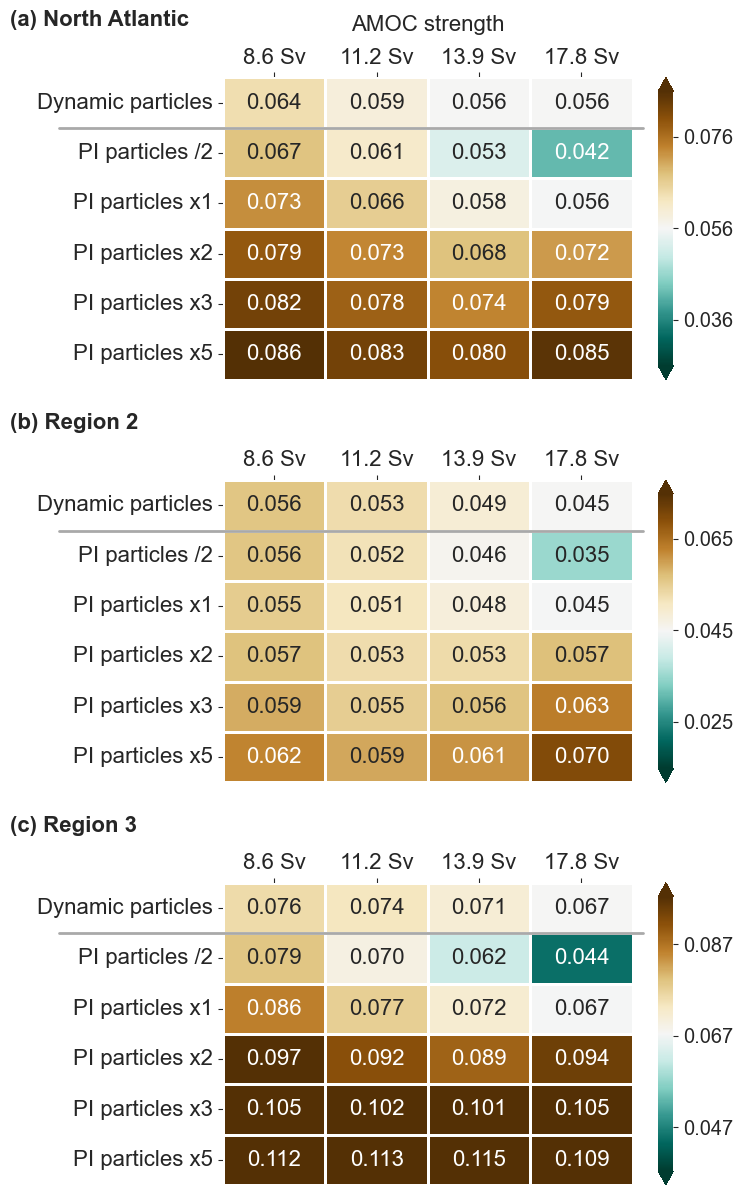

In [22]:
# PLOT MULTIPLE HEAT MAPS IN MULTI-PANEL FIGURE

######## SETTINGS ##########################
these_domains = ['NAtl', 2, 3]        # for Fig. 9
# these_domains = ['SAtl', 'Atl', 1, 4]  # for Fig. S8
### pick domains from: 'NAtl', 'SAtl', 'Atl' (case sensitive!); or integer 1, 2, 3 or 4 (region number)

more_decimals = False   # either 3 or 4 decimals are printed depending on this setting
cbar = True
fs = 16                 # fontsize

# settings for cmap:
## either colors w.r.t. CTRL
colors_to_ctrl = True
## or colors identical to Fig. 7a (used if colors_to_ctrl = False)
this_cmap = cmcr.vik
vmin = 0.03  # vmin and vmax s.t. 0.093 is in the middle
vmax = 0.156

# settings for thick horizontal line
this_ls = 'solid'
this_lw = 2.0
############################################

print('these_domains:', these_domains)
domain_labels = {'NAtl': 'North Atlantic', 'SAtl': 'South Atlantic', 'Atl': 'Atlantic', 
                 1: 'Region 1', 2: 'Region 2', 3: 'Region 3', 4: 'Region 4'}

fig, ax = plt.subplots(len(these_domains), figsize=(8,4*len(these_domains)))

for row, domain in enumerate(these_domains):
   assert domain in ['NAtl', 'SAtl', 'Atl', 1,2,3,4], 'domain must be NAtl, SAtl or Atl (as string) or 1,2,3,4 (as integer)'

   ## PREPARATION - SORT INFORMATION FOR HEATMAP
   if isinstance(domain, int):
      this_PaTh_bottom_avg = PaTh_bottom_avg_region[domain]
   else:
      if domain == 'NAtl':
         this_PaTh_bottom_avg = NAtl_PaTh_bottom_avg
      elif domain == 'SAtl':
         this_PaTh_bottom_avg = SAtl_PaTh_bottom_avg
      elif domain == 'Atl':
         this_PaTh_bottom_avg = entire_Atl_PaTh_bottom_avg

   # prepare values used for heatmap colours
   detectability_PaTh_bottom_2d_array = [[this_PaTh_bottom_avg[run] for run in ['PFREE_09SV', 'PFREE_11SV', 'PFREE_14SV', 'CTRL_NEWNR']],
                                       [this_PaTh_bottom_avg[run] for run in ['PFD2__09SV', 'PFD2__11SV', 'PFD2__14SV', 'PFD2__18SV']],
                                       [this_PaTh_bottom_avg[run] for run in ['PFX1__09SV', 'PFX1__11SV', 'PFX1__14SV', 'PFX1__18SV']],
                                       [this_PaTh_bottom_avg[run] for run in ['PFX2__09SV', 'PFX2__11SV', 'PFX2__14SV', 'PFX2__18SV']],
                                       [this_PaTh_bottom_avg[run] for run in ['PFX3__09SV', 'PFX3__11SV', 'PFX3__14SV', 'PFX3__18SV']],
                                       [this_PaTh_bottom_avg[run] for run in ['PFX5__09SV', 'PFX5__11SV', 'PFX5__14SV', 'PFX5__18SV']]]

   if more_decimals:  # with 4 decimals
      this_fmt = "{:.4f}"
   else:  # with 3 decimals
      this_fmt = "{:.3f}"

   # prepare same values now as strings used for annotation inside the heatmap
   detectability_PaTh_bottom_2d_array_str = [[this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFREE_09SV', 'PFREE_11SV', 'PFREE_14SV', 'CTRL_NEWNR']],
                                             [this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFD2__09SV', 'PFD2__11SV', 'PFD2__14SV', 'PFD2__18SV']],
                                             [this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFX1__09SV', 'PFX1__11SV', 'PFX1__14SV', 'PFX1__18SV']],
                                             [this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFX2__09SV', 'PFX2__11SV', 'PFX2__14SV', 'PFX2__18SV']],
                                             [this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFX3__09SV', 'PFX3__11SV', 'PFX3__14SV', 'PFX3__18SV']],
                                             [this_fmt.format(this_PaTh_bottom_avg[run]) for run in ['PFX5__09SV', 'PFX5__11SV', 'PFX5__14SV', 'PFX5__18SV']]]

   detectability_PaTh_bottom_2d_array = np.asarray(detectability_PaTh_bottom_2d_array)
   detectability_PaTh_bottom_2d_array_str = np.asarray(detectability_PaTh_bottom_2d_array_str, dtype=str)

   ## PLOTTING
   if colors_to_ctrl:
      # define colormap with CTRL Pap/Thp in the middle
      ref = this_PaTh_bottom_avg['CTRL_NEWNR']
      delta = 0.03
      this_cmap = cmp.BrBG_r
      vmin = ref - delta
      vmax = ref + delta
      # cbar_ticks = np.arange(0.04, vmax, 0.02)   # no, lacks information
      cbar_ticks = np.arange(np.round(ref,3) - 0.04, vmax, 0.02) # nicely around ref, but only 3 ticks
      # cbar_ticks = np.arange(np.round(ref,3) - 0.06, vmax, 0.01) # more ticks, still ugly
   else:
      cbar_ticks = np.arange(0.04, vmax, 0.02)

   xlabels = ['8.6 Sv', '11.2 Sv', '13.9 Sv', '17.8 Sv']
   ylabels = ['Dynamic particles','PI particles /2','PI particles x1','PI particles x2','PI particles x3','PI particles x5']
   ax[row] = sns.heatmap(detectability_PaTh_bottom_2d_array, robust=True, linewidths=2, fmt="",
                        xticklabels=xlabels, yticklabels=ylabels, cmap=this_cmap, vmin=vmin, vmax=vmax, 
                        cbar=cbar, cbar_kws={'extend' : 'both', 'ticks' : cbar_ticks}, # 'label' : 'Pa/Th'}, # or $\Delta Pa_p/Th_p$
                        annot=detectability_PaTh_bottom_2d_array_str, annot_kws={'size': fs}, ax=ax[row])
   ax[row].set_xticklabels(ax[row].get_xticklabels(), fontsize=fs)
   ax[row].set_yticklabels(ax[row].get_yticklabels(), fontsize=fs)
   ax[row].tick_params(labelsize=fs)
   ax[row].xaxis.tick_top()
   if row == 0:
      ax[row].set_title('AMOC strength', pad=12, fontsize=fs)
   else:
      ax[row].set_title('\n', pad=12, fontsize=fs)

   # plot line between dynamic particles and scaled particles
   line = matplotlib.lines.Line2D([-1.6, 4.1], [1,1], c='darkgrey', ls=this_ls, lw=this_lw)
   line.set_clip_on(False)
   ax[row].add_line(line)

   # add a), b) etc with title
   ax[row].text(-0.52, 1.17, '(' + chr(ord('a')+row) + ') ' + domain_labels[domain], transform=ax[row].transAxes, 
               size=fs, weight='bold')
   
plt.tight_layout()

plt.savefig(savedir / ('fig9_heatmap_PaTh_bottom_multiple_domains.pdf'))
# plt.savefig(savedir / ('fig9_heatmap_PaTh_bottom_multiple_domains.png'), dpi=300)

# Fig. 3b, 10: depth profiles per region

Take a few regions in the West Atlantic, in the deep part in the direction of the Mid-Atlantic Ridge (but not there yet). And in regions where observations presents. The notes below are summarized in the regions dict:
- NE of Bermuda Rise in direction of MAR: 24-25 by 33-35 (OR 34-35)
  - includes 2 sw data and 2 sediment
- Bermuda Rise: 21-23 (OR 21-22 OR 22-23) by 30-31 
  - includes 1 sw and 1 sed
  - NB: Bermuda Rise region is 32-36N and -66 to -57 E; in grid cells this would be 30-31 by 21-22 so 2x2
- Ceara Rise (Venezuela in direction of MAR): 22-24 by 26-27
  - includes 1 sw data point and 2 clusters of sediment.
- off northern Brasil: 24-25 by 21-23
  - includes 3 sediment cores + 1 cluster of sediment cores
- off southern Brasil: 26-27 by 14-16
  - includes 2 sw data points + just outside of 1 sediment core  

In [23]:
######### SETTINGS FOR ALL PLOTS BELOW #####################
# Define small regions of interest in the Atlantic; 
# just 4-6 water columns s.t. not drawing conclusions from 1 water column/grid cell
# form: [[lon_start, lon_end],[lat_start,lat_end]] with indices as Bern3D map i.e. starting from 1
regions = {1: [[25,26], [31,33]], # NE of Bermuda Rise / south of GRL
           2: [[20,22], [28,30]],  # Bermuda Rise
           3: [[23,25], [20,25]],  # off Venezuela & northern Brasil
           4: [[24,26], [13,16]],  # off southern Brasil
           }

colors_AMOC = ['k'] + list(cmp.Blues_r([0.1, 0.55, 0.85 ]))  # used in Fig. 10
ls_AMOC = ['solid', 'dashdot', 'dashed', 'solid']            # linestyles in Fig. 10
labels_AMOC = ['17.8 Sv', '14 Sv', '11 Sv', '8.6 Sv']
########################################
assert len(colors_AMOC) == len(labels_AMOC), "colors_AMOC and labels_AMOC must have same length"
assert len(ls_AMOC) == len(labels_AMOC), "ls_AMOC and labels_AMOC must have same length"

### Fig. 3b: regions map 
Is combined with panel a, c and d in fig3_maps.pptx

regions setting: {1: [[25, 26], [31, 33]], 2: [[20, 22], [28, 30]], 3: [[23, 25], [20, 25]], 4: [[24, 26], [13, 16]]} 

Region 1 is  321.5 - 328.5 lon and 37.5 - 47.5 N (T-grid)
Region 2 is  286.0 - 300.5 lon and 22.5 - 32.5 N (T-grid)
Region 3 is  307.5 - 321.5 lon and -4.5 - 10.5 N (T-grid)
Region 4 is  314.5 - 328.5 lon and -32.5 - -17.5 N (T-grid)




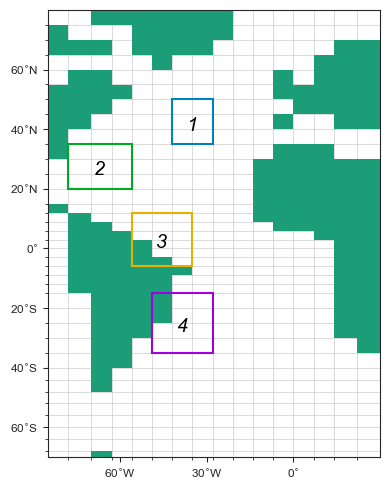

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,5))

ax = f.plot_regions_map(ax, data_fulls[runs[0]], regions=regions,  # 'regions' could be omitted as default has same regions
                        verbose=True, lw=1.5, Bern3D_grid=True,
                        colors=['#0082c1', '#00ab23', '#e6af02', '#a300df'])  # color regions as in Fig. 3a
                        # colors=['k'] * 4)                                   # color regions black
ax.set_title("")

# set domain & yticks equal to Fig. 3a (map of cores):
ax.set_xlim(275,390)  # domain [85W, 30E] is [275,390] in Bern3D coordinates
ax.set_ylim(-70,80)
ax.set_yticks(range(-60,70,20))

# add '°W' etc
ax = f.convert_ticks_of_map(ax, Bern3D_grid=True, font="Arial")

# smaller ticklabels
ax.tick_params(axis='x', labelsize=8.5)
ax.tick_params(axis='y', labelsize=8.5)

plt.tight_layout()
plt.savefig(savedir / ('fig3b_regions_map.pdf'))

### Fig. 10

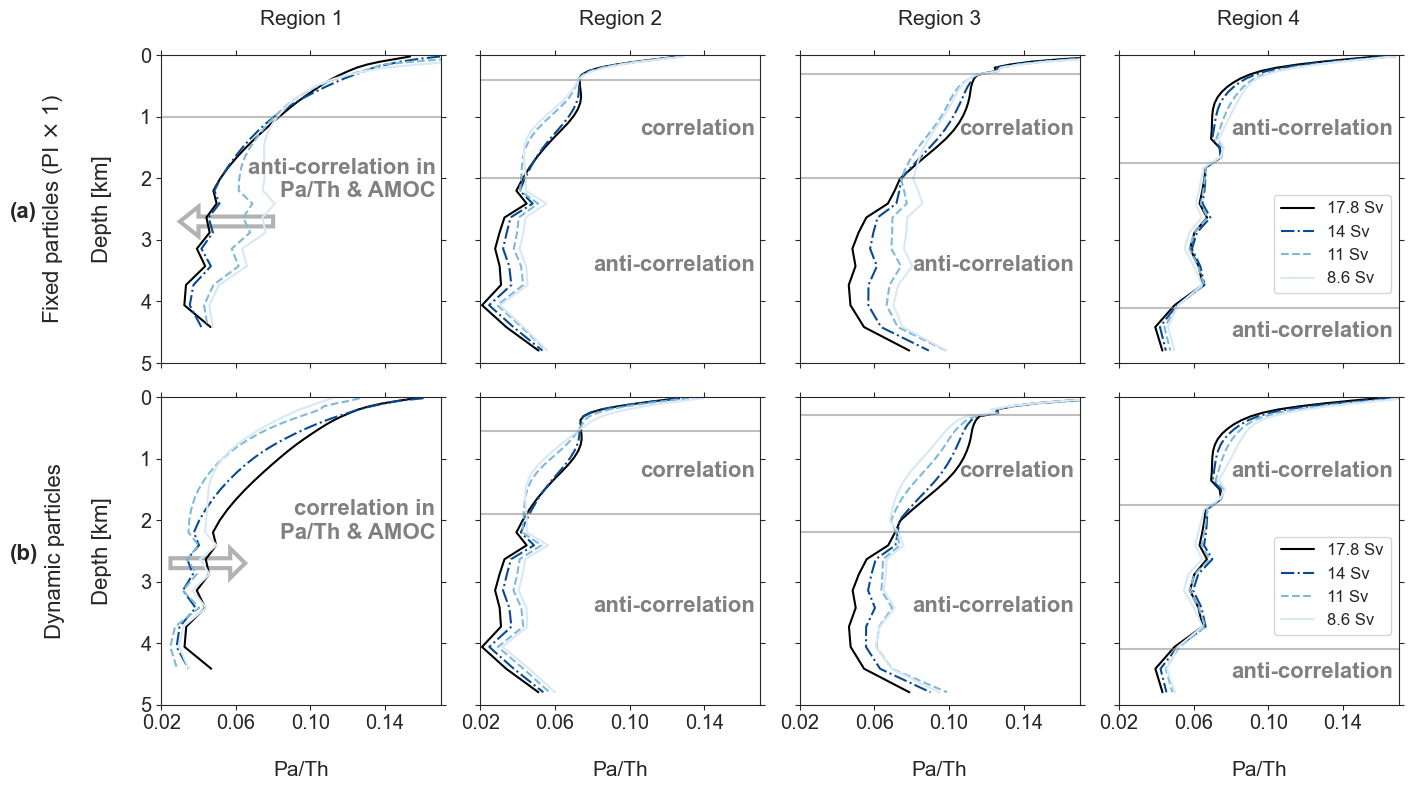

In [25]:
# plot of Pap/Thp vs. depth per region 
# VERSION: Row 1 fixed particles; row 2 dynamic particles; without observations

######### SETTINGS #####################
anom = False      # w.r.t. surface value
zoom = False     # cut off first km; for better visibility / interpretation
c_obs = 'k'
ymax = 5.0      # km
annotate = True  # indicate regimes of (anti-)correlation between Pa/Th and AMOC
row_labels = [r'Fixed particles (PI $\times$ 1)', 'Dynamic particles']
## version with only CTRL:
# runs_per_row = [[PFX1__18SV],
#                 [ctrl]]  # ALSO ADJUST row_labels!
## version with all AMOCs (as in manuscript):
runs_per_row = [[PFX1__18SV, PFX1__14SV, PFX1__11SV, PFX1__09SV], 
                [ctrl, PFREE_14SV, PFREE_11SV, PFREE_09SV]]  # ALSO ADJUST row_labels!
########################################
assert len(row_labels) == len(runs_per_row), "Labels of subplot must have same length as runs_per_subplot"
assert not (anom and zoom), "Combining anom and zoom is not useful"
if annotate:
    assert not(anom or zoom), "Cannot combine annotate with anom or zoom"

# preparations
model_lon = data_fulls[runs[0]].lon_t.values
model_lat = data_fulls[runs[0]].lat_t.values

# start figure
fig, ax = plt.subplots(len(row_labels), 4, figsize=(14, 4*len(row_labels)))  # 4 cols because 4 regions

for row in range(len(row_labels)):
    ax[row,0].set_ylabel(row_labels[row] + "\n\nDepth [km]\n", fontsize=16)
    for region_nr, [lons,lats] in regions.items():
        assert len(lons) == 2 and len(lats) == 2, "lons and lats of regions dict need to have length 2"
        col = region_nr-1
        
        for n,run in enumerate(runs_per_row[row]):
            # slice model result of this run to region:
            # lon_start-1 to convert to python index; lon_end-1 +1 as [] excludes last
            model_region = data_fulls[run].isel(time=t, lon_t=slice(lons[0]-1,lons[1]), 
                                                lat_t=slice(lats[0]-1,lats[1]))

            plot_obj = f.area_mean(data_fulls[run], model_region['path_ratio_p'])
            if anom:
                ax[row,col].plot(plot_obj.values-plot_obj.values[0], plot_obj.z_t, 
                                 c=colors_AMOC[n], ls=ls_AMOC[n], label=labels_AMOC[n])
            else:
                ax[row,col].plot(plot_obj.values, plot_obj.z_t, 
                                 c=colors_AMOC[n], ls=ls_AMOC[n], label=labels_AMOC[n])

        if zoom:
            ax[row,col].set_ylim(1,ymax)
            ax[row,col].set_yticks(range(1,6))
        else:
            ax[row,col].set_ylim(0,ymax)
            ax[row,col].set_yticks(range(0,6))
        ax[row,col].invert_yaxis()
        if anom:
            ax[row,col].set_xlim(-0.16,0.0)
            ax[row,col].set_xticks([-0.15, -0.1, -0.05, 0])
            ax[row,col].set_xticklabels(["-0.15", "-0.10", "-0.05", "0"])
        elif zoom:
            ax[row,col].set_xlim(0.02, 0.11)
            ax[row,col].set_xticks([0.02, 0.06, 0.10])
        else:
            ax[row,col].set_xlim(0.02, 0.17)
            ax[row,col].set_xticks(np.arange(0.02, 0.18, 0.04))

        if row == 0:
            ax[row,col].set_title("Region " + str(region_nr) + "\n", fontsize=15)
            ax[row,col].set_xticklabels([])
        else:
            if anom:
                ax[row,col].set_xlabel("\nPa/Th - Pa/Th[z=0]", fontsize=14)
            else:
                ax[row,col].set_xlabel("\nPa/Th", fontsize=15)
        if col != 0:
            ax[row,col].set_yticklabels([])

        ax[row,col].tick_params(axis='both', bottom=True, top=True, left=True, right=True)

ax[0,3].legend(loc='lower right', fontsize=12, bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
ax[1,3].legend(loc='lower right', fontsize=12, bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
for row in [0,1]:
    ax[row,0].text(-0.54, 0.47, '(' + chr(ord('a')+row) + ')', transform=ax[row,0].transAxes, 
                   size=16, weight='bold')

if annotate:
    kwargs = {'size' : 16, 'fontweight' : 'bold', 'c' : 'gray'}
    ra = 0.167  # right alignment boundary of text

    ### Region 1 manual
    ax[0,0] = f.add_line(ax[0,0], 1.0, c='grey', alpha=0.5) # line at 1 km
    ax[0,0].text(ra, 2.3, 'anti-correlation in\nPa/Th & AMOC', kwargs, ha='right')
    ax[1,0].text(ra, 2.3, 'correlation in\nPa/Th & AMOC', kwargs, ha='right')
    
    #### Region 2-4 in for loop
    ## horizontal lines at depths where CTRL and weak AMOC runs intersect
    # (ax_object) : [km_lines]
    hor_lines_per_ax = {(0,1):[0.4, 2.0], (0,2):[0.3, 2.0], (0,3):[1.75, 4.1], 
                        (1,1):[0.55, 1.9], (1,2):[0.3, 2.2], (1,3):[1.75, 4.1]}
    ## text 'correlation' or 'anti-correlation'                   
    # (ax_object) : [x, y] of right-aligned text position 
    correlation_text_per_ax = {(0,1): [ra,1.3], (0,2): [ra,1.3], 
                               (1,1): [ra,1.3], (1,2): [ra,1.3]}
    anticorrelation_text_per_ax = {(0,1): [ra,3.5], (0,2): [ra,3.5], (0,3): [ra,1.3], 
                                   (1,1): [ra,3.5], (1,2): [ra,3.5], (1,3): [ra,1.3]}
    for row in [0,1]:
        for col in [1,2,3]:
            ax[row,col] = f.add_line(ax[row,col], hor_lines_per_ax[(row,col)], c='grey', alpha=0.5)
            if col != 3:  # no significant correlation in region 4; obj empty for those
                [x,y] = correlation_text_per_ax[row,col]
                ax[row,col].text(x,y, 'correlation', kwargs, ha='right')
            [x,y] = anticorrelation_text_per_ax[row,col]
            ax[row,col].text(x,y, 'anti-correlation', kwargs, ha='right')
    # manually add a 2nd anti-correlation text in region 4
    [x,y]=[ra,4.57]
    ax[0,3].text(x,y, 'anti-correlation', kwargs, ha='right')
    ax[1,3].text(x,y, 'anti-correlation', kwargs, ha='right')
    # add arrows
    arrow = matplotlib.patches.Arrow(x=0.08, y=2.7, dx=-0.05, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.8)
    ax[0,0].add_patch(arrow)
    arrow = matplotlib.patches.Arrow(x=0.025, y=2.7, dx=0.04, dy=0, color=kwargs['c'], fill=False, 
                                     lw=3, alpha=0.6, width=0.8)
    ax[1,0].add_patch(arrow)

plt.tight_layout()
if anom:
    plt.savefig(savedir / ('path_regions_fixed_dynamic_anom.pdf'))
elif zoom:
    plt.savefig(savedir / ('path_regions_fixed_dynamic_zoom.pdf'))
else:
    plt.savefig(savedir / ('fig10_path_regions_fixed_dynamic.pdf'))
    
# by design row 1 and 2 are practically identical for 17.8 Sv

# Fig. S5-S7: assess model development via Atl. zonal avg

figure_nr: 5
VERSION A: seawater Pa_d, Th_d and seawater Pa_p / Th_p
timestep: t= -1 

Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
Performing a weighted average (weights=1/error) in cells with >1 obs, with error propagation.
Function obs_to_model_grid(): done.
runs in order of rows:
n= 0 so runname= CTRL_NEWNR and run label= CTRL @yr 5000 

n= 1 so runname= NO_NEPH___ and run label= NO_NEPH @yr 5000 



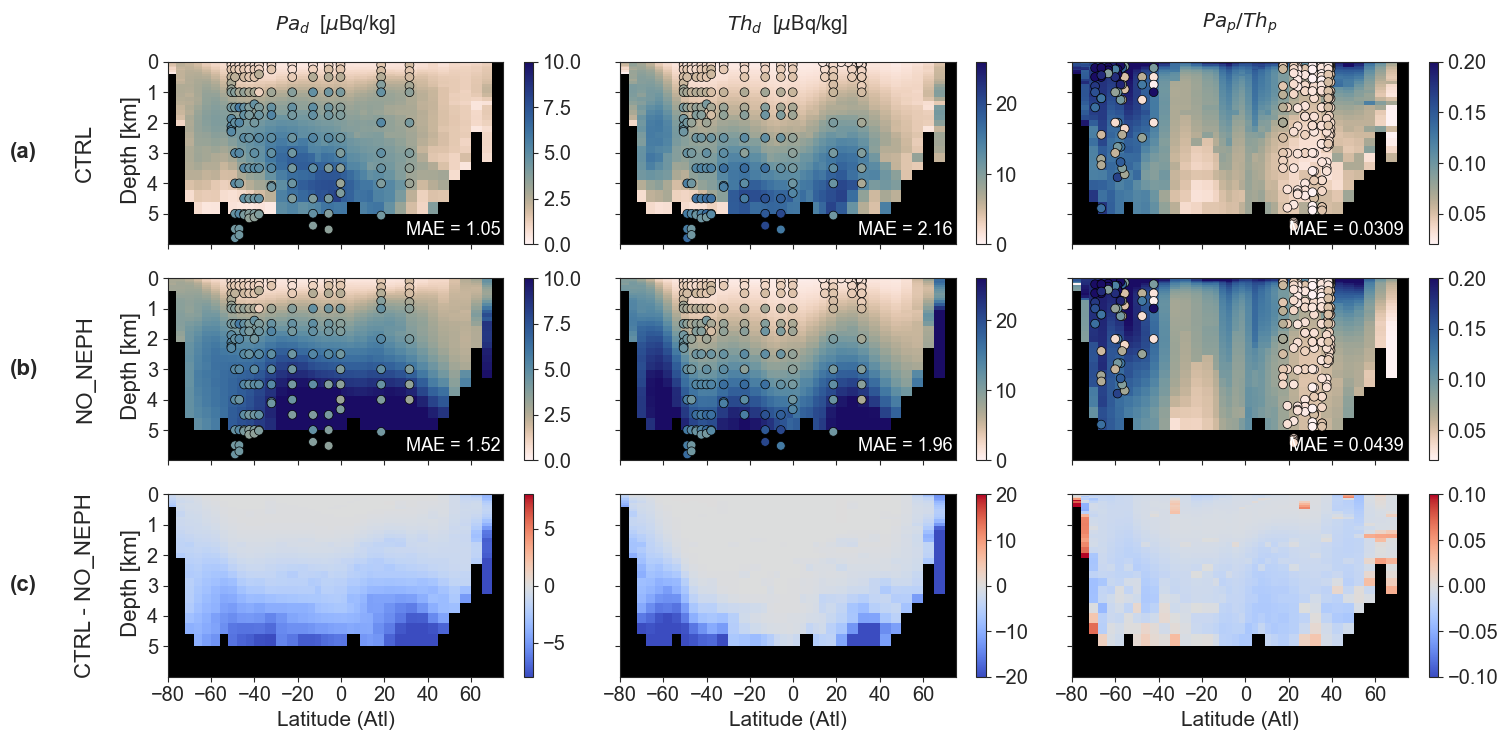

In [26]:
# zonal average in Atl for 2 runs + anomaly [optional]
# ===============================================================================
# VERSION A (AS IN MANUSCRIPT): 
# seawater Pa_d, Th_d (GA02 or entire Atl) and seawater Pa_p / Th_p (only GA03 and GIPY05)
# ===============================================================================

##################### SETTINGS ######################################################
figure_nr = 5          # choose from '5' (neph), '6' (dust), '7' (old remineralization term)

obs = True
sw_entire_atl = False  # otherwise we only use GA02 (West Atl) sw data (as in paper)
anomaly = True         # add 3rd row with anomaly plot
anom_free = False      # overwrites anom_zoom_in
print_mae = True       # prints MAE in the panels; desired but slower
verbose = False        # also print MAEs as text as check
rectangular = True     # make figure broader; more suitable for 16:9 slides
cmap = cmcr.lapaz_r
t=-1                   # output time step to plot

# set colour scale boundaries:
vmins = {'Pad' : 0.0, 'Thd' : 0.0, 'Pap' : 0.0, 'Thp' : 0.0, 
         'path_ratio_d' : 0.0, 'path_ratio_p' : 0.02}
vmaxs = {'Pad' : 10, 'Thd' : 26, 'Pap' : 0.4, 'Thp' : 6, 
         'path_ratio_d' : 1, 'path_ratio_p' : 0.2}
# settings for vmaxs_anom are below, depending on which figure_nr
##################### END OF SETTINGS ###############################################
print('figure_nr:', figure_nr)
print('VERSION A: seawater Pa_d, Th_d and seawater Pa_p / Th_p')
print("timestep: t=",t, '\n')

# define runs to use
if figure_nr == 5:    # Fig. S5
    these_runs = [ctrl, NO_NEPH]
    vmaxs_anom = {'Pad' : 8, 'Thd' : 20, 'path_ratio_p' : 0.1}
elif figure_nr == 6:  # Fig. S6
    these_runs = [ctrl, NO_DUST]
    vmaxs_anom = {'Pad' : 4, 'Thd' : 10, 'path_ratio_p' : 0.1}
elif figure_nr == 7:  # Fig. S7
    these_runs = [ADD_REM, ctrl]
    vmaxs_anom = {'Pad' : 0.5, 'Thd' : 0.5, 'path_ratio_p' : 0.05}
else:
    # a general setting to play around with Atl zonal averages + anomalies of other runs
    # these_runs =   # NEED TO FILL IN RUNS HERE IF PLAYING AROUND
    vmaxs_anom = {'Pad' : 2, 'Thd' : 4, 'path_ratio_p' : 0.1}
assert figure_nr in [5,6,7], "need to set figure_nr to 5, 6 or 7 (for neph, dust resp. remineralization term)"
assert len(these_runs) > 1, "This plot needs more than 1 run"

# prepare seawater Pa_d, Th_d
if sw_entire_atl:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises='all')
else:
    [this_sw, this_sw_obs_d_ave, junk2] = f.subset_of_obs(obs_d, fnctrl, cruises=['GA02', 'GAc02'])

# prepare seawater Pap/Thp
this_obs_p = obs_p.where(obs_p.path_ratio_p.notnull()).dropna(how='all')      # keep only obs with ratio
# add uncertainty of ration via error propagation for division
this_obs_p['path_ratio_p_err'] = this_obs_p.path_ratio_p * (this_obs_p.Pap_err / this_obs_p.Pap + this_obs_p.Thp_err / this_obs_p.Thp)
this_obs_p.drop(columns=['Pap','Pap_err','Thp','Thp_err'], inplace=True)
# GA03 and GIPY05 are the only Atl cruises with Pap AND Thp obs:
[this_obs_p, this_sw_obs_p_ave, junk2] = f.subset_of_obs(this_obs_p, fnctrl, cruises=['GA03', 'GIPY05']) 

sns.set_style("ticks")
if anomaly:
    nr_rows = len(these_runs)+1
else:
    nr_rows = len(these_runs)
if rectangular:
    fig, ax = plt.subplots(nr_rows,3, figsize=(15,2.5*nr_rows))
else:
    fig, ax = plt.subplots(nr_rows,3, figsize=(13,3.5*nr_rows))

xlist = data_fulls[these_runs[0]].lat_u
ylist = data_fulls[these_runs[0]].z_w
X, Y = np.meshgrid(xlist, ylist)

print('runs in order of rows:')
for n,run in enumerate(these_runs):
    print('n=',n,'so runname=', run, 'and run label=', labels[run], 
          "@yr " + str(int(np.ceil(data_fulls[run].time[t].item()))), '\n')
    obj = data_fulls[run]

    # dissolved Atl average
    pad_global = f.model_to_sw_unit(obj.Pad.isel(time=t), obj.rho_SI.isel(time=t))
    thd_global = f.model_to_sw_unit(obj.Thd.isel(time=t), obj.rho_SI.isel(time=t))
    pad = pad_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thd = thd_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        

    # particle-bound Atl average
    pap_global = f.model_to_sw_unit(obj.Pap.isel(time=t), obj.rho_SI.isel(time=t))
    thp_global = f.model_to_sw_unit(obj.Thp.isel(time=t), obj.rho_SI.isel(time=t))
    pap = pap_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True) 
    thp = thp_global.where(obj.masks == 1).mean(dim='lon_t', skipna=True)        
    ratio = pap / thp

    if anomaly:
        # save objects
        if n==0:
            pad_run0 = pad
            thd_run0 = thd
            ratio_run0 = ratio
        if n==1:
            pad_run1 = pad
            thd_run1 = thd
            ratio_run1 = ratio                

    # Pa_d in col 1
    cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
    fig.colorbar(cpf, ax=ax[n,0])

    # Th_d in col 2
    cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
    fig.colorbar(cpf, ax=ax[n,1])

    if print_mae:
        # compute MAEs for col 1,2
        # get model data of the grid cells with obs:
        [res_d_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                              obs_ave=this_sw_obs_d_ave, convert_unit_to_obs=True)
        [weights_Pad, weights_Thd] = f.find_weights(this_sw_obs_d_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_Pad = f.calc_mae(model=res_d_table.Pad, observation=this_sw_obs_d_ave.Pad, 
                                  weights=weights_Pad, verbose=verbose)
        this_MAE_Thd = f.calc_mae(model=res_d_table.Thd, observation=this_sw_obs_d_ave.Thd, 
                                  weights=weights_Thd, verbose=verbose)

        # add MAEs to plot for col 1,2
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,0].text(30, 5.7, f'MAE = {this_MAE_Pad:.2f}', kwargs)
        ax[n,1].text(30, 5.7, f'MAE = {this_MAE_Thd:.2f}', kwargs)

    # ratio Pa_p / Th_p in col 3
    cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
    fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[n]] + "\n\n Depth [km]", fontsize=16)

    if print_mae:
        # compute MAEs for col 3
        # get model data of the grid cells with obs:
        [res_p_table, res_entire] = f.get_sim(memberid=run, path=modeldir, ensemble='FREE', 
                                              obs_ave=this_sw_obs_p_ave, convert_unit_to_obs=True)
        res_p_table['path_ratio_p'] = res_p_table.Pap / res_p_table.Thp # add ratio manually        
        weights_path_ratio_p = f.find_weights(this_sw_obs_p_ave, res_entire, volume=False, uncertainty=True)
        this_MAE_path_ratio_p = f.calc_mae(model=res_p_table.path_ratio_p, observation=this_sw_obs_p_ave.path_ratio_p, 
                                           weights=weights_path_ratio_p, verbose=verbose)

        # add MAEs to plot for col 3
        kwargs = {'size' : 13, 'color' : 'white'}
        ax[n,2].text(20, 5.7, f'MAE = {this_MAE_path_ratio_p:.4f}', kwargs)

    if obs:
        ## ADD SEAWATER OBSERVATIONS TO COL 1,2,3
        ax[n,0].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Pad, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Pad'], vmax=vmaxs['Pad'])
        # colors c convert to cmap/vmin/vmax cbar automatically; size s and linewidth lw in pixels
        ax[n,1].scatter(x=this_sw.lat, y=this_sw.z/1000.0, c=this_sw.Thd, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['Thd'], vmax=vmaxs['Thd'])
        ax[n,2].scatter(x=this_obs_p.lat, y=this_obs_p.z/1000.0, c=this_obs_p.path_ratio_p, 
                        marker='o', s=40, lw=0.5, edgecolor='k', 
                        cmap=cmap, vmin=vmins['path_ratio_p'], vmax=vmaxs['path_ratio_p'])
# add 3rd row with anomaly
if anomaly:
    n = 2  # row number for in axis object
    cmap = cmp.coolwarm

    # dissolved Atl average
    pad = pad_run0 - pad_run1
    thd = thd_run0 - thd_run1 

    # particle-bound Atl average
    ratio = ratio_run0 - ratio_run1

    if anom_free:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,(ratio).values, cmap=cmap)
        fig.colorbar(cpf, ax=ax[n,2])
    else:
        cpf = ax[n,0].pcolormesh(X,Y,pad.values, cmap=cmap, vmin=-vmaxs_anom['Pad'], vmax=vmaxs_anom['Pad'])
        fig.colorbar(cpf, ax=ax[n,0])
        cpf = ax[n,1].pcolormesh(X,Y,thd.values, cmap=cmap, vmin=-vmaxs_anom['Thd'], vmax=vmaxs_anom['Thd'])
        fig.colorbar(cpf, ax=ax[n,1])
        cpf = ax[n,2].pcolormesh(X,Y,ratio.values, cmap=cmap, vmin=-vmaxs_anom['path_ratio_p'], vmax=vmaxs_anom['path_ratio_p'])
        fig.colorbar(cpf, ax=ax[n,2])

    ax[n,0].set_ylabel(labels[these_runs[0]] + " - " + labels[these_runs[1]] + "\n\n Depth [km]", fontsize=16)

for i in range(0, nr_rows):
    for j in range(0, 3):
        ax[i,j].invert_yaxis()
        ax[i,j].set_xlim(-80,75)
        ax[i,j].set_xticks(range(-80,65,20))
        ax[i,j].set_yticks(range(0,6))
        ax[i,j].set_facecolor('k')  # turn ocean topography black
        if j != 0:
            ax[i,j].set_yticklabels([])  # clean ticks
        if anomaly:
            ax[len(these_runs),j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs):
                ax[i,j].set_xticklabels([])  # clean ticks
        else:
            ax[len(these_runs)-1,j].set_xlabel('Latitude (Atl)', fontsize=15)
            if i < len(these_runs)-1:
                ax[i,j].set_xticklabels([])  # clean ticks
        if obs:
            # go to 6 km instead of 5 km such that all subplots have same depth
            ax[i,j].set_ylim(6,0)  # deepest obs at 5815 m
        if j == 0:
            ax[i,j].text(-0.47, 0.47, '(' + chr(ord('a')+i) + ')', transform=ax[i,j].transAxes, 
                         size=16, weight='bold')

ax[0,0].set_title("$Pa_d$  [$\mu$Bq/kg]" + "\n")
ax[0,1].set_title("$Th_d$  [$\mu$Bq/kg]" + "\n")
ax[0,2].set_title("$Pa_p/Th_p$" + " \n")

plt.tight_layout()
if obs:
    obs_label = '_obs_'
    if sw_entire_atl:
        # seawater: entire Atl
        obs_label += 'entire_atl_' 
    else:
        # seawater: GA02 (West transect); sediment: entire Atl
        obs_label += 'sw_GA02_sed_entire_atl_'
else:
    obs_label = '_no_obs_'
plt.savefig(savedir / ("figS" + str(figure_nr) + obs_label + labels[these_runs[0]] + "_" + labels[these_runs[1]] + '.pdf'))